In [87]:
import pandas as pd
from tcrdist.repertoire import TCRrep
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
pd.set_option('display.max_columns', None)
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import numpy as np

human combined

In [88]:
new_data=pd.read_csv('human_combined.csv')
new_data

,Unnamed: 0,complex.id,gene_x,cdr3_a_aa,v_a_gene,j_a_gene,species,epitope,antigen.species,vdjdb.score,gene_y,cdr3_b_aa,v_b_gene,j_b_gene
0,0,15,TRA,CAVAGYGGSQGNLIF,TRAV12-2*01,TRAJ42*01,HomoSapiens,ELAGIGILTV,HomoSapiens,1,TRB,CASSPQGLGTEAFF,TRBV28*01,TRBJ1-1*01
1,1,114,TRA,CAGAGSQGNLIF,TRAV27*01,TRAJ42*01,HomoSapiens,GILGFVFTL,InfluenzaA,3,TRB,CASSSRSSYEQYF,TRBV19*01,TRBJ2-7*01
2,2,138,TRA,CAGAGSQGNLIF,TRAV27*01,TRAJ42*01,HomoSapiens,GILGFVFTL,InfluenzaA,3,TRB,CASSSRASYEQYF,TRBV19*01,TRBJ2-7*01
3,3,146,TRA,CARNTGNQFYF,TRAV24*01,TRAJ49*01,HomoSapiens,NLVPMVATV,CMV,3,TRB,CASSPVTGGIYGYTF,TRBV6-5*01,TRBJ1-2*01
4,4,148,TRA,CAVNVAGKSTF,TRAV12-2*01,TRAJ27*01,HomoSapiens,ELAGIGILTV,HomoSapiens,3,TRB,CAWSETGLGTGELFF,TRBV30*01,TRBJ2-2*01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,801,29622,TRA,CAFLNAGGTSYGKLTF,TRAV38-1*01,TRAJ52*01,HomoSapiens,QYIKWPWYI,SARS-CoV-2,1,TRB,CASSWNGLAGDEQFF,TRBV6-2*01,TRBJ2-1*01
802,802,29623,TRA,CAVYNQGGKLIF,TRAV8-1*01,TRAJ23*01,HomoSapiens,QYIKWPWYI,SARS-CoV-2,1,TRB,CASSALVAFSTDTQYF,TRBV6-4*01,TRBJ2-3*01
803,803,29624,TRA,CAVRALYNFNKFYF,TRAV3*01,TRAJ21*01,HomoSapiens,QYIKWPWYI,SARS-CoV-2,1,TRB,CASSSLAGEVNEQFF,TRBV7-2*01,TRBJ2-1*01
804,804,29625,TRA,CAVESYNTDKLIF,TRAV41*01,TRAJ34*01,HomoSapiens,QYIKWPWYI,SARS-CoV-2,1,TRB,CASSSYTQRGLDYTGELFF,TRBV27*01,TRBJ2-2*01


In [89]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(new_data, test_size=0.2,stratify=new_data['epitope'], random_state=20)

# 保存到CSV
train_df.to_csv('train_human.csv', index=False)
test_df.to_csv('test_human.csv', index=False)


In [90]:
##train tr
df_train = pd.read_csv('train_human.csv')

tr = TCRrep(cell_df=df_train,
            chains = ['alpha','beta'],
            organism='human',
            deduplicate=True)

X = pd.DataFrame(tr.pw_alpha + tr.pw_beta)
Y = tr.clone_df['epitope']

D:\conda\Lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
D:\conda\Lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


In [91]:
# dfs for storing metrics 
metrics_cv_df = pd.DataFrame(columns=['AUC', 'Accuracy', 'Recall', 'Precision'])
auc_cv_df = pd.DataFrame(columns=Y.unique())
recall_cv_df = pd.DataFrame(columns=Y.unique())
precision_cv_df = pd.DataFrame(columns=Y.unique())


# df for storing predictions (for confusion matrix)
preds_df = pd.DataFrame(columns=['y_true', 'y_pred'], index=Y.index)       
#确定k
k_cv=5
best_value=0
metrics = []
kfolds = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=20)
kfolds.get_n_splits(X)
for k_neighbours  in range(1,10) :
    for train_ind, test_ind in kfolds.split(X, Y):
        # split data
        X_train, X_test = X.iloc[train_ind, train_ind], X.iloc[test_ind, train_ind]
        Y_train, Y_test = Y.iloc[train_ind], Y.iloc[test_ind]

        # train model
        model = KNeighborsClassifier(n_neighbors=k_neighbours, metric='precomputed', weights='distance') 
        model.fit(X_train, Y_train.ravel())

        # get predictions
        preds_labels = model.predict(X_test)
        preds_prob = model.predict_proba(X_test)

        # store in df
        preds_df.loc[Y_test.index, 'y_true'] = Y_test.loc[Y_test.index].values
        preds_df.loc[Y_test.index, 'y_pred'] = preds_labels

        ###--- calculate performance metrics

        # calculate & store average metrics
        Y_test_matrix = OneHotEncoder(categories=[model.classes_]).fit_transform(Y_test.values.reshape(-1, 1)).toarray()

        roc_auc_fold = roc_auc_score(Y_test_matrix, preds_prob, multi_class='ovr', average='macro')
        accuracy_fold = accuracy_score(Y_test, preds_labels)
        precision_fold = precision_score(Y_test, preds_labels, average='macro') # macro - simplest, unweighted mean between all classes
        recall_fold = recall_score(Y_test, preds_labels, average='macro') # macro - simplest, unweighted mean between all classes

        metrics.append(pd.Series({'AUC': roc_auc_fold, 'Accuracy': accuracy_fold, 
                                                        'Recall': recall_fold, 'Precision': precision_fold}))
    metric_df = pd.DataFrame(metrics)
    average_df= metric_df.mean()
    if best_value < average_df['AUC']+average_df['Accuracy']+average_df['Recall']+average_df['Precision'] :
        best_value = average_df['AUC']+average_df['Accuracy']+average_df['Recall']+average_df['Precision']
        best_k = k_neighbours
    metrics = []

print(best_k)

D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in l

5


D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
k_neighbours=5
metrics = []
auc=[]
recall=[]
precision=[]
kfolds = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=20)
kfolds.get_n_splits(X)

# perform CV

    
for train_ind, test_ind in kfolds.split(X, Y):
    # split data
    X_train, X_test = X.iloc[train_ind, train_ind], X.iloc[test_ind, train_ind]
    Y_train, Y_test = Y.iloc[train_ind], Y.iloc[test_ind]

    # train model
    model = KNeighborsClassifier(n_neighbors=k_neighbours, metric='precomputed', weights='distance') 
    model.fit(X_train, Y_train.ravel())

    # get predictions
    preds_labels = model.predict(X_test)
    preds_prob = model.predict_proba(X_test)

    # store in df
    preds_df.loc[Y_test.index, 'y_true'] = Y_test.loc[Y_test.index].values
    preds_df.loc[Y_test.index, 'y_pred'] = preds_labels

    ###--- calculate performance metrics

    # calculate & store average metrics
    Y_test_matrix = OneHotEncoder(categories=[model.classes_]).fit_transform(Y_test.values.reshape(-1, 1)).toarray()

    roc_auc_fold = roc_auc_score(Y_test_matrix, preds_prob, multi_class='ovr', average='macro')
    accuracy_fold = accuracy_score(Y_test, preds_labels)
    precision_fold = precision_score(Y_test, preds_labels, average='macro') # macro - simplest, unweighted mean between all classes
    recall_fold = recall_score(Y_test, preds_labels, average='macro') # macro - simplest, unweighted mean between all classes

    metrics.append(pd.Series({'AUC': roc_auc_fold, 'Accuracy': accuracy_fold, 
                                                    'Recall': recall_fold, 'Precision': precision_fold}))

    # calculate & store AUC per epitope
    roc_auc_epitopes = roc_auc_score(Y_test_matrix, preds_prob, multi_class='ovr', average=None)
    auc.append(pd.Series(roc_auc_epitopes, index=model.classes_))

    # calculate & store recall per epitope
    recall_epitopes = recall_score(Y_test, preds_labels, average=None)
    recall.append(pd.Series(recall_epitopes, index=model.classes_))

    # calculate & store recall per epitope
    precision_epitopes = precision_score(Y_test, preds_labels, average=None)
    precision.append(pd.Series(precision_epitopes, index=model.classes_))
    

metric_df = pd.DataFrame(metrics)
auc_df = pd.DataFrame(auc)
precision_df = pd.DataFrame(precision)
recall_df = pd.DataFrame(recall)
metric_df

D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in l

,AUC,Accuracy,Recall,Precision
0,0.870638,0.720930,0.626684,0.624304
1,0.814428,0.620155,0.453608,0.455236
2,0.829772,0.635659,0.551159,0.572932
3,0.834696,0.689922,0.561304,0.526172
4,0.805554,0.695312,0.554829,0.548477


In [93]:
average_metric = metric_df.mean()
average_metric

AUC          0.831017
Accuracy     0.672396
Recall       0.549516
Precision    0.545424
dtype: float64

In [94]:
# get confusion matrices
epitopes = list(preds_df['y_true'].unique())
conf_mat_dash = pd.DataFrame(confusion_matrix(preds_df['y_true'], preds_df['y_pred']), columns=epitopes, index=epitopes)
conf_mat_dash_norm = pd.DataFrame(confusion_matrix(preds_df['y_true'], preds_df['y_pred'], normalize='true'), columns=epitopes, index=epitopes)

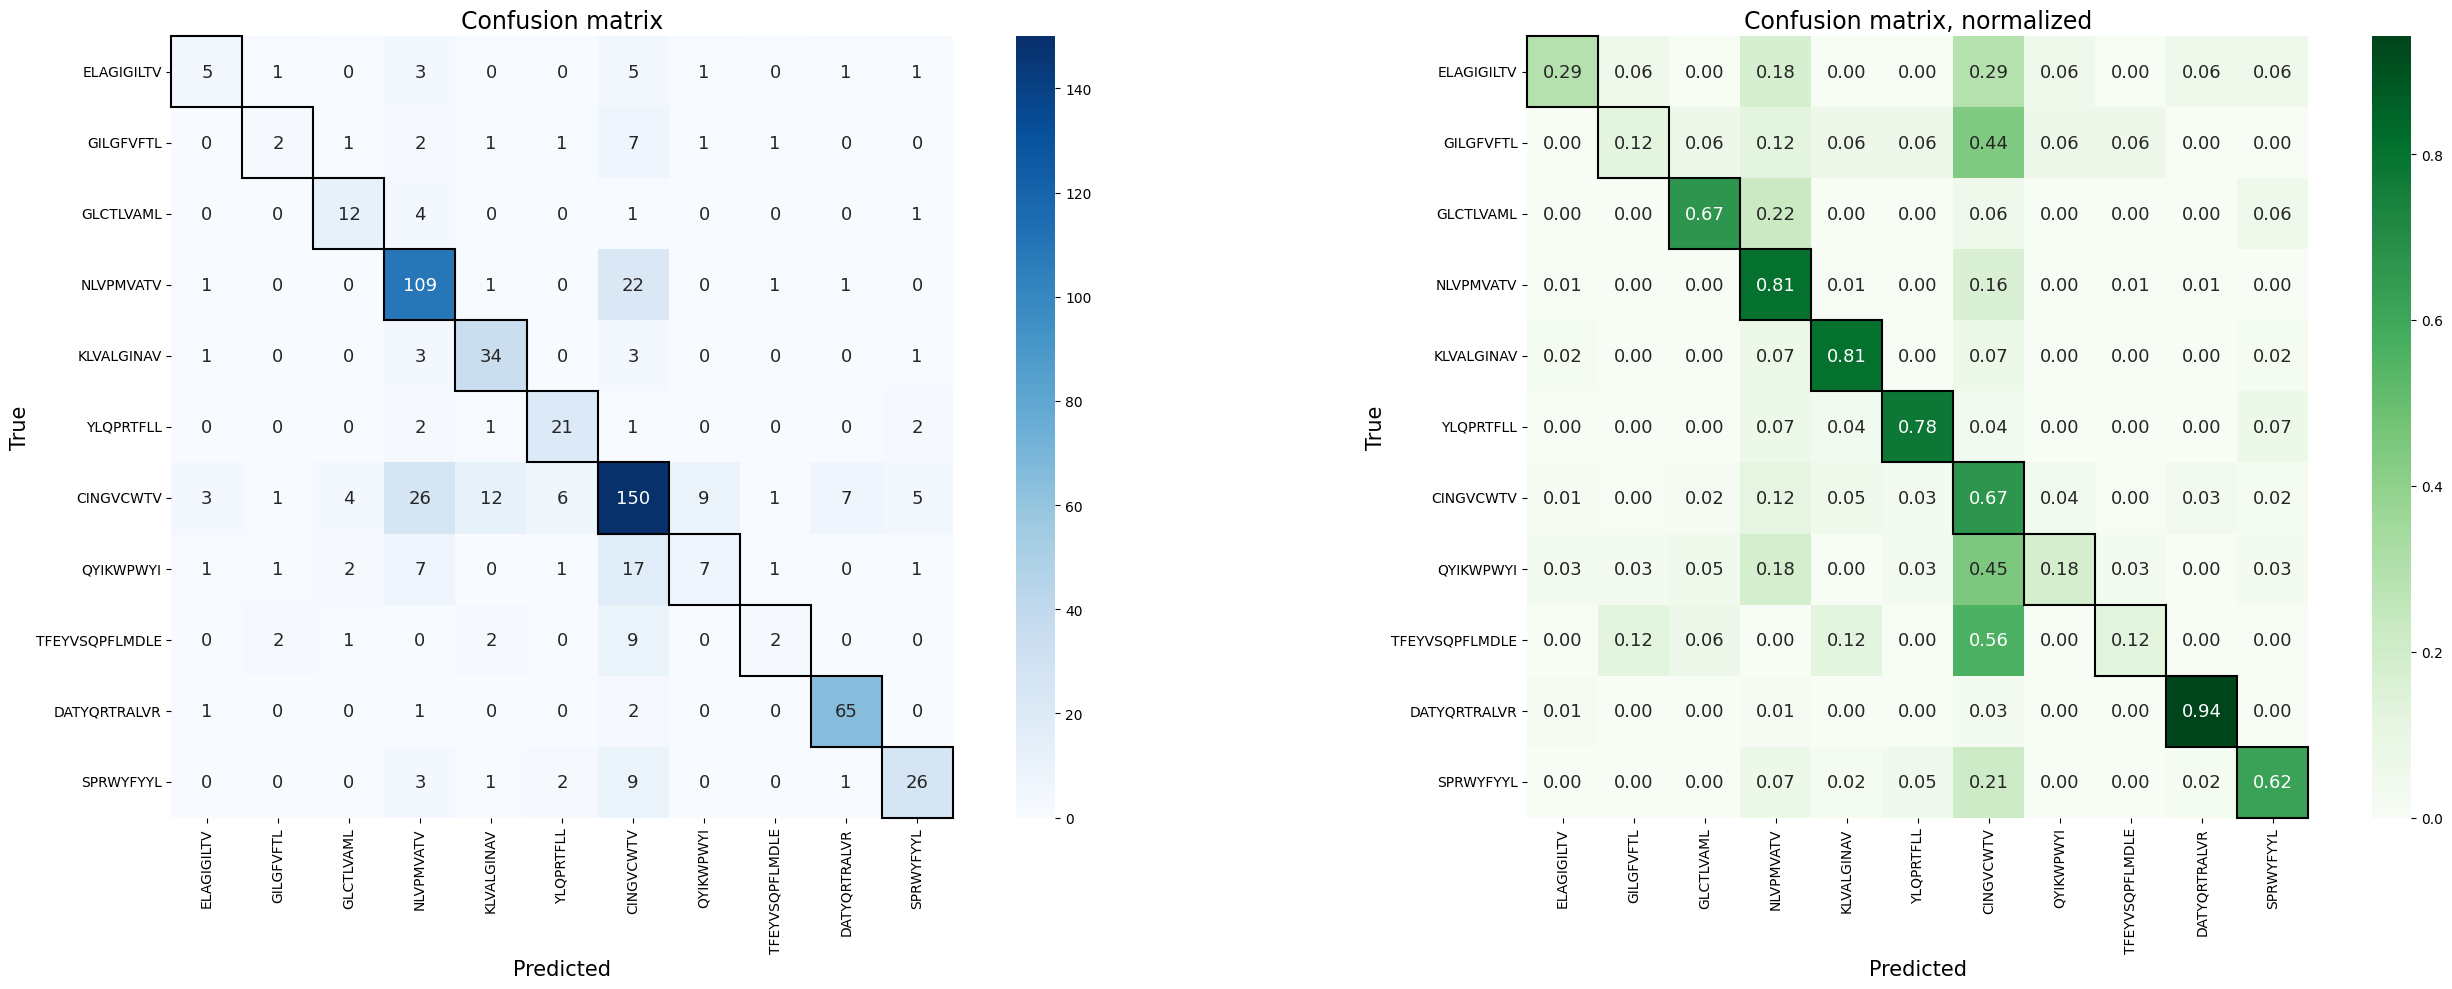

In [95]:
# plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28,10))
sns.set_context(font_scale=1.3)
sns.heatmap(conf_mat_dash, annot=True, cmap='Blues', fmt='', ax=axes[0], square=True, annot_kws={"size": 13}, vmin=0)
axes[0].set_xlabel('Predicted', fontsize=15)
axes[0].set_ylabel('True', fontsize=15)
axes[0].set_title('Confusion matrix', fontsize=17)

sns.heatmap(conf_mat_dash_norm, annot=True, cmap='Greens', fmt='.2f', ax=axes[1], square=True, annot_kws={"size": 13}, vmin=0)
axes[1].set_title('Confusion matrix, normalized', fontsize=17)
axes[1].set_xlabel('Predicted', fontsize=15)
axes[1].set_ylabel('True', fontsize=15)

for epi_ind in range(conf_mat_dash.shape[0]):
    axes[0].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))
    axes[1].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))

plt.tight_layout()

In [96]:
# train model on entire train set
Y_binarized = label_binarize(Y, classes=np.unique(Y))
model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=k_neighbours, metric='precomputed', weights='distance'))
model.fit(X, Y.values.ravel())

OneVsRestClassifier(estimator=KNeighborsClassifier(metric='precomputed',
                                                   weights='distance'))

In [97]:
# 获取测试 TCR 和训练 TCR 之间的 tcrdist 距离
df_test= pd.read_csv('test_human.csv')
tcrrep_test = TCRrep(cell_df=df_test,
                     organism='human',
                     chains=['alpha','beta'],
                     deduplicate=True)

tcrrep_test.compute_rect_distances(df=tcrrep_test.clone_df,
                                    df2=tr.clone_df)

X_test = pd.DataFrame(tcrrep_test.rw_alpha + tcrrep_test.rw_beta)
# get predictions
preds_prob = model.predict_proba(X_test)
preds_labels = model.predict(X_test)
# get test data labels
Y_test = tcrrep_test.clone_df['epitope']

D:\conda\Lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
D:\conda\Lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


In [98]:
#Calculate performance metrics
metrics = {}
metrics['accuracy'] = accuracy_score(Y_test, preds_labels)
metrics['roc_auc'] = roc_auc_score(Y_test, pd.DataFrame(preds_prob, columns=model.classes_), average='macro', multi_class='ovr')

metrics['confusion_matrix'] = pd.DataFrame(confusion_matrix(Y_test, preds_labels), columns=model.classes_, index=model.classes_)
metrics['confusion_matrix_norm'] = pd.DataFrame(confusion_matrix(Y_test, preds_labels, normalize='true'), columns=model.classes_, index=model.classes_)

metrics_df = pd.DataFrame(columns=model.classes_)
metrics_df.loc['precision'] = precision_score(Y_test, preds_labels, average=None)
metrics_df.loc['recall'] = recall_score(Y_test, preds_labels, average=None)
metrics_df.loc['f1'] = f1_score(Y_test, preds_labels, average=None)

In [99]:
print(metrics['accuracy'])
print(metrics['roc_auc'])

0.7222222222222222
0.829447347677328


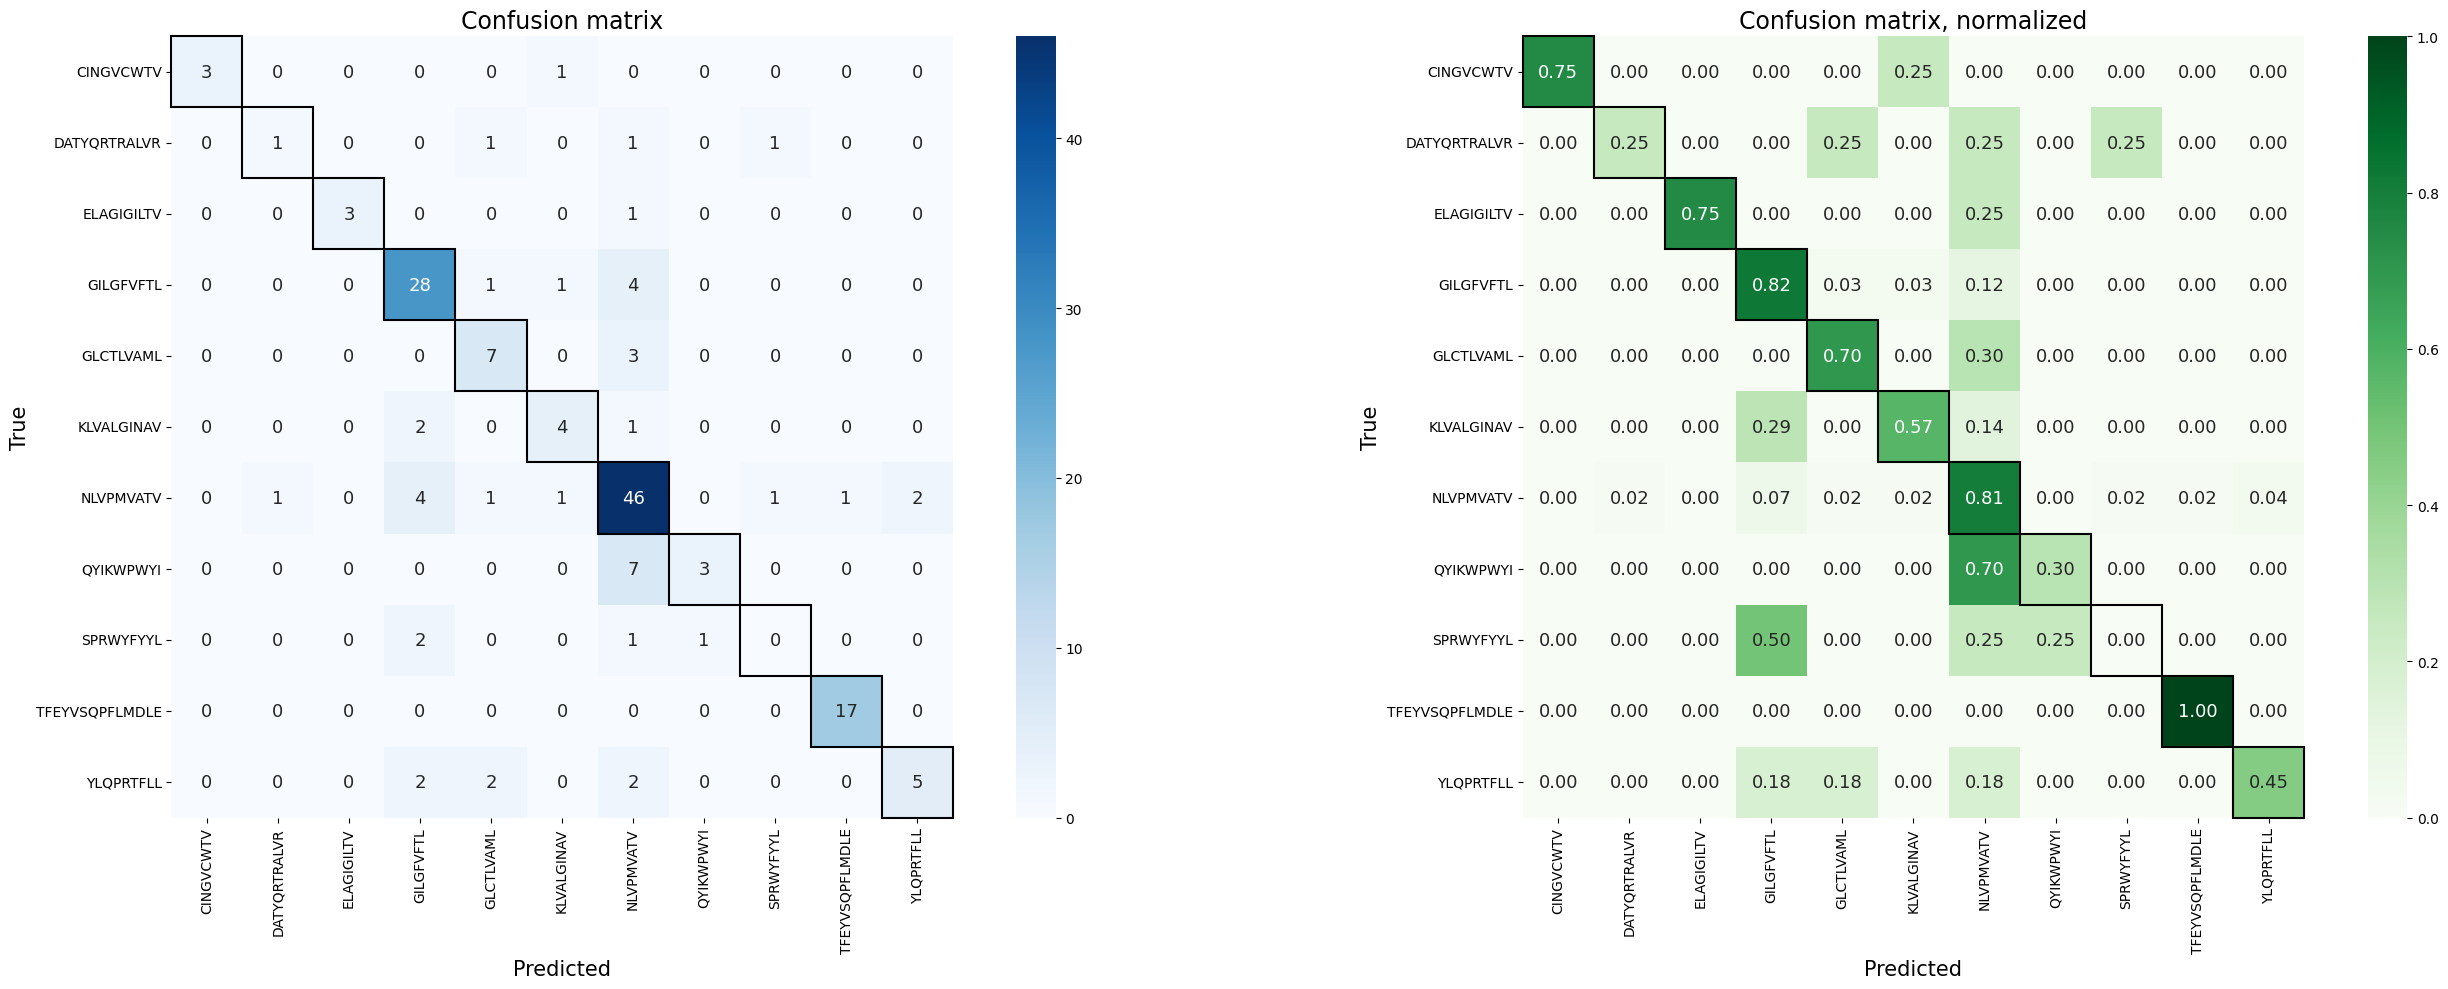

In [100]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28,10))
sns.set_context(font_scale=1.1)
sns.heatmap(metrics['confusion_matrix'], annot=True, cmap='Blues', fmt='', ax=axes[0], square=True, annot_kws={"size": 13})
axes[0].set_xlabel('Predicted', fontsize=15)
axes[0].set_ylabel('True', fontsize=15)
axes[0].set_title('Confusion matrix', fontsize=17)
for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)

sns.heatmap(metrics['confusion_matrix_norm'], annot=True, cmap='Greens', fmt='.2f', ax=axes[1], square=True, annot_kws={"size": 13})
axes[1].set_title('Confusion matrix, normalized', fontsize=17)
axes[1].set_xlabel('Predicted', fontsize=15)
axes[1].set_ylabel('True', fontsize=15)
for tick in axes[1].get_xticklabels():
        tick.set_rotation(90)

for epi_ind in range(metrics['confusion_matrix'].shape[0]):
    axes[0].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))
    axes[1].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))

plt.tight_layout()

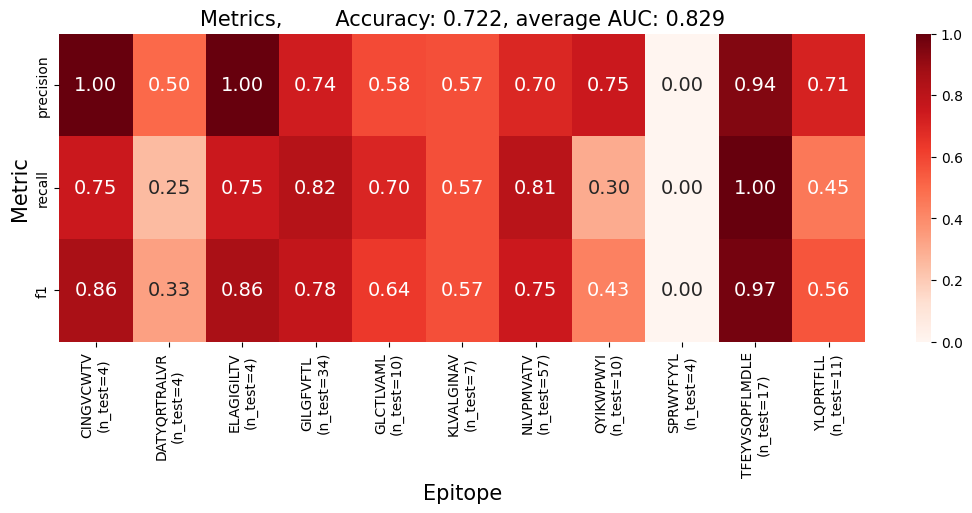

In [101]:
plt.figure(figsize=(13,4))
ax = sns.heatmap(metrics_df, annot=True, cmap='Reds', fmt='.2f', annot_kws={"size": 14}, vmin=0, vmax=1)
ax.set_ylabel('Metric', fontsize=15)
ax.set_xlabel('Epitope', fontsize=15)
ax.set_title(f"Metrics,        Accuracy: {metrics['accuracy']:.3f}, average AUC: {metrics['roc_auc']:.3f}", fontsize=15)
_ = ax.set_xticklabels([epi + f'\n(n_test={(Y_test==epi).sum()})' for epi in metrics_df.columns])

In [102]:
metrics_df

,CINGVCWTV,DATYQRTRALVR,ELAGIGILTV,GILGFVFTL,GLCTLVAML,KLVALGINAV,NLVPMVATV,QYIKWPWYI,SPRWYFYYL,TFEYVSQPFLMDLE,YLQPRTFLL
precision,1.000000,0.500000,1.000000,0.736842,0.583333,0.571429,0.696970,0.750000,0.0,0.944444,0.714286
recall,0.750000,0.250000,0.750000,0.823529,0.700000,0.571429,0.807018,0.300000,0.0,1.000000,0.454545
f1,0.857143,0.333333,0.857143,0.777778,0.636364,0.571429,0.747967,0.428571,0.0,0.971429,0.555556


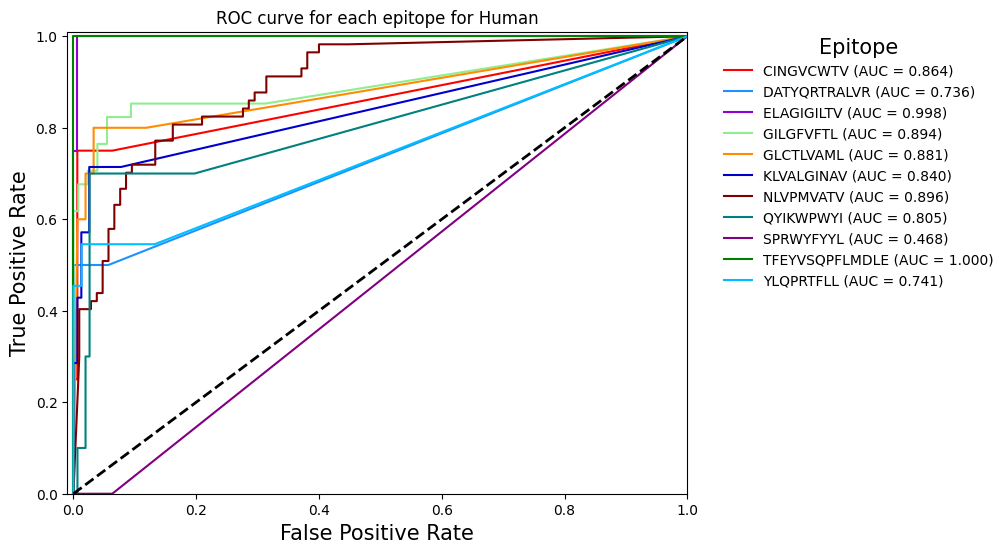

In [103]:
from tcrdist.repertoire import TCRrep
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
Y_matrix = pd.get_dummies(tcrrep_test.clone_df['epitope'])
colors = ['red', 'dodgerblue', 'darkviolet', 'lightgreen', 'darkorange', 'mediumblue', 'maroon', 'teal', 'purple', 'green', 'deepskyblue', 'yellowgreen', 'lightcoral', 'gold', ]
# Get ROC curve info for each epitope
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, ep in enumerate(model.classes_):
    fpr[ep], tpr[ep], _ = roc_curve(Y_matrix.loc[:, ep], preds_prob[:, i])
    roc_auc[ep] = auc(fpr[ep], tpr[ep])

# Plot ROC curves
fig, ax = plt.subplots(figsize=(8, 6))
for ep, color in zip(model.classes_, colors):
    ax.plot(fpr[ep], tpr[ep], color=color, lw=1.5, label=f'{ep} (AUC = {roc_auc[ep]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC curve for each epitope for Human')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False, title='Epitope')
_ = plt.setp(ax.get_legend().get_title(), fontsize=15)
plt.savefig('roc_curve_human.png')
plt.show()

human alpha

In [112]:
new_data=pd.read_csv('human_alpha.csv')
new_data

,Unnamed: 0,complex.id,gene,cdr3_a_aa,v_a_gene,j_a_gene,species,epitope,antigen.species,vdjdb.score
0,0,107,TRA,CAVSESPFGNEKLTF,TRAV8-4*01,TRAJ48*01,HomoSapiens,PKYVKQNTLKLAT,InfluenzaA,3
1,1,114,TRA,CAGAGSQGNLIF,TRAV27*01,TRAJ42*01,HomoSapiens,GILGFVFTL,InfluenzaA,3
2,2,130,TRA,CAVQASGGSYIPTF,TRAV1-2*01,TRAJ6*01,HomoSapiens,EPLPQGQLTAY,EBV,3
3,3,139,TRA,CAGAGSQGNLIF,TRAV27*01,TRAJ42*01,HomoSapiens,PKYVKQNTLKLAT,InfluenzaA,3
4,4,140,TRA,CAVSGGYQKVTF,TRAV8-4*01,TRAJ13*01,HomoSapiens,KAFSPEVIPMF,HIV-1,3
...,...,...,...,...,...,...,...,...,...,...
914,914,29623,TRA,CAVYNQGGKLIF,TRAV8-1*01,TRAJ23*01,HomoSapiens,QYIKWPWYI,SARS-CoV-2,1
915,915,29624,TRA,CAVRALYNFNKFYF,TRAV3*01,TRAJ21*01,HomoSapiens,QYIKWPWYI,SARS-CoV-2,1
916,916,29625,TRA,CAVESYNTDKLIF,TRAV41*01,TRAJ34*01,HomoSapiens,QYIKWPWYI,SARS-CoV-2,1
917,917,0,TRA,CLVGENSGGFKTIF,TRAV4*01,TRAJ9*01,HomoSapiens,QYIKWPWYI,SARS-CoV-2,1


In [113]:
train_df, test_df = train_test_split(new_data, test_size=0.2,stratify=new_data['epitope'], random_state=20)

# 保存到CSV
train_df.to_csv('train_human.csv', index=False)
test_df.to_csv('test_human.csv', index=False)


In [114]:
##train tr
df_train = pd.read_csv('train_human.csv')

tr = TCRrep(cell_df=df_train,
            chains = ['alpha'],
            organism='human',
            deduplicate=True)

X = pd.DataFrame(tr.pw_alpha )
Y = tr.clone_df['epitope']

D:\conda\Lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
D:\conda\Lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


In [115]:
# dfs for storing metrics 
metrics_cv_df = pd.DataFrame(columns=['AUC', 'Accuracy', 'Recall', 'Precision'])
auc_cv_df = pd.DataFrame(columns=Y.unique())
recall_cv_df = pd.DataFrame(columns=Y.unique())
precision_cv_df = pd.DataFrame(columns=Y.unique())


# df for storing predictions (for confusion matrix)
preds_df = pd.DataFrame(columns=['y_true', 'y_pred'], index=Y.index)       
#确定k
k_cv=5
best_value=0
metrics = []
kfolds = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=20)
kfolds.get_n_splits(X)
for k_neighbours  in range(1,10) :
    for train_ind, test_ind in kfolds.split(X, Y):
        # split data
        X_train, X_test = X.iloc[train_ind, train_ind], X.iloc[test_ind, train_ind]
        Y_train, Y_test = Y.iloc[train_ind], Y.iloc[test_ind]

        # train model
        model = KNeighborsClassifier(n_neighbors=k_neighbours, metric='precomputed', weights='distance') 
        model.fit(X_train, Y_train.ravel())

        # get predictions
        preds_labels = model.predict(X_test)
        preds_prob = model.predict_proba(X_test)

        # store in df
        preds_df.loc[Y_test.index, 'y_true'] = Y_test.loc[Y_test.index].values
        preds_df.loc[Y_test.index, 'y_pred'] = preds_labels

        ###--- calculate performance metrics

        # calculate & store average metrics
        Y_test_matrix = OneHotEncoder(categories=[model.classes_]).fit_transform(Y_test.values.reshape(-1, 1)).toarray()

        roc_auc_fold = roc_auc_score(Y_test_matrix, preds_prob, multi_class='ovr', average='macro')
        accuracy_fold = accuracy_score(Y_test, preds_labels)
        precision_fold = precision_score(Y_test, preds_labels, average='macro') # macro - simplest, unweighted mean between all classes
        recall_fold = recall_score(Y_test, preds_labels, average='macro') # macro - simplest, unweighted mean between all classes

        metrics.append(pd.Series({'AUC': roc_auc_fold, 'Accuracy': accuracy_fold, 
                                                        'Recall': recall_fold, 'Precision': precision_fold}))
    metric_df = pd.DataFrame(metrics)
    average_df= metric_df.mean()
    if best_value < average_df['AUC']+average_df['Accuracy']+average_df['Recall']+average_df['Precision'] :
        best_value = average_df['AUC']+average_df['Accuracy']+average_df['Recall']+average_df['Precision']
        best_k = k_neighbours
    metrics = []

print(best_k)

D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in l

7


D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [116]:
k_neighbours=7

In [117]:
# train model on entire train set
Y_binarized = label_binarize(Y, classes=np.unique(Y))
model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=k_neighbours, metric='precomputed', weights='distance'))
model.fit(X, Y.values.ravel())

OneVsRestClassifier(estimator=KNeighborsClassifier(metric='precomputed',
                                                   n_neighbors=7,
                                                   weights='distance'))

In [118]:
# 获取测试 TCR 和训练 TCR 之间的 tcrdist 距离
df_test= pd.read_csv('test_human.csv')
tcrrep_test = TCRrep(cell_df=df_test,
                     organism='human',
                     chains=['alpha'],
                     deduplicate=True)

tcrrep_test.compute_rect_distances(df=tcrrep_test.clone_df,
                                    df2=tr.clone_df)

X_test = pd.DataFrame(tcrrep_test.rw_alpha )
# get predictions
preds_prob = model.predict_proba(X_test)
preds_labels = model.predict(X_test)
# get test data labels
Y_test = tcrrep_test.clone_df['epitope']

D:\conda\Lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
D:\conda\Lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


In [119]:
#Calculate performance metrics
metrics = {}
metrics['accuracy'] = accuracy_score(Y_test, preds_labels)
metrics['roc_auc'] = roc_auc_score(Y_test, pd.DataFrame(preds_prob, columns=model.classes_), average='macro', multi_class='ovr')

metrics['confusion_matrix'] = pd.DataFrame(confusion_matrix(Y_test, preds_labels), columns=model.classes_, index=model.classes_)
metrics['confusion_matrix_norm'] = pd.DataFrame(confusion_matrix(Y_test, preds_labels, normalize='true'), columns=model.classes_, index=model.classes_)

metrics_df = pd.DataFrame(columns=model.classes_)
metrics_df.loc['precision'] = precision_score(Y_test, preds_labels, average=None)
metrics_df.loc['recall'] = recall_score(Y_test, preds_labels, average=None)
metrics_df.loc['f1'] = f1_score(Y_test, preds_labels, average=None)

In [120]:
print(metrics['accuracy'])
print(metrics['roc_auc'])

0.5434782608695652
0.8058158438365441


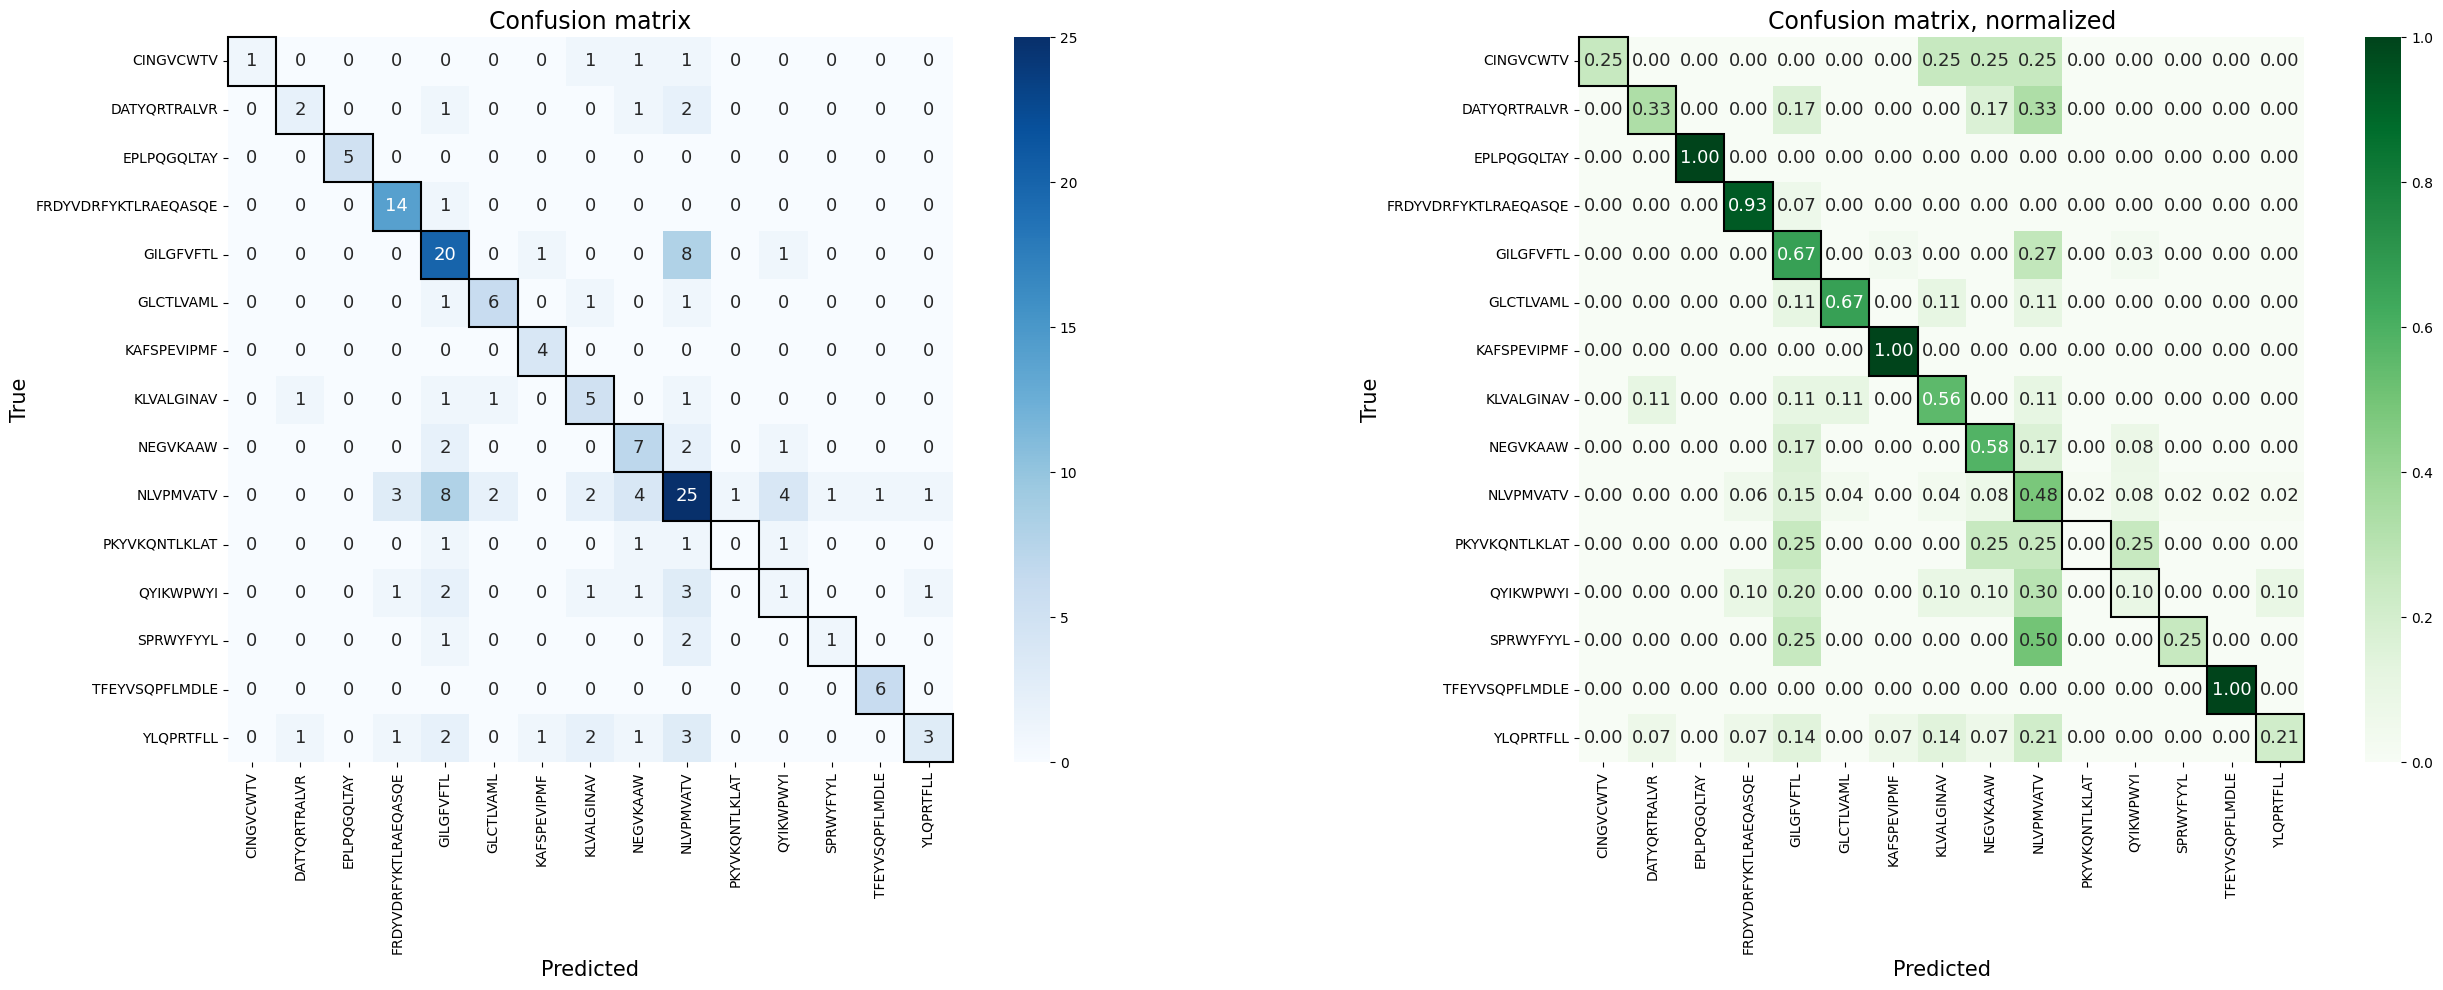

In [121]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28,10))
sns.set_context(font_scale=1.1)
sns.heatmap(metrics['confusion_matrix'], annot=True, cmap='Blues', fmt='', ax=axes[0], square=True, annot_kws={"size": 13})
axes[0].set_xlabel('Predicted', fontsize=15)
axes[0].set_ylabel('True', fontsize=15)
axes[0].set_title('Confusion matrix', fontsize=17)
for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)

sns.heatmap(metrics['confusion_matrix_norm'], annot=True, cmap='Greens', fmt='.2f', ax=axes[1], square=True, annot_kws={"size": 13})
axes[1].set_title('Confusion matrix, normalized', fontsize=17)
axes[1].set_xlabel('Predicted', fontsize=15)
axes[1].set_ylabel('True', fontsize=15)
for tick in axes[1].get_xticklabels():
        tick.set_rotation(90)

for epi_ind in range(metrics['confusion_matrix'].shape[0]):
    axes[0].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))
    axes[1].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))

plt.tight_layout()

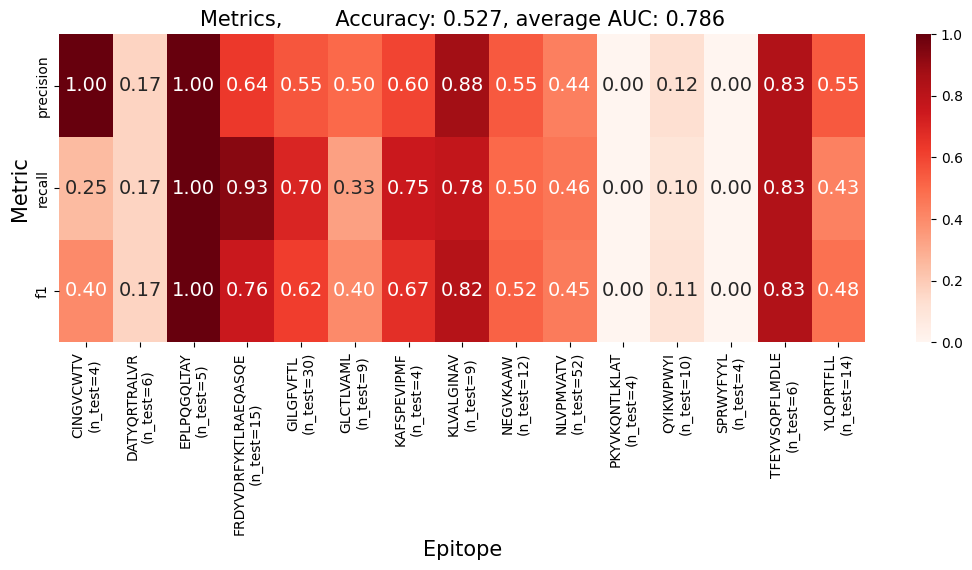

In [73]:
plt.figure(figsize=(13,4))
ax = sns.heatmap(metrics_df, annot=True, cmap='Reds', fmt='.2f', annot_kws={"size": 14}, vmin=0, vmax=1)
ax.set_ylabel('Metric', fontsize=15)
ax.set_xlabel('Epitope', fontsize=15)
ax.set_title(f"Metrics,        Accuracy: {metrics['accuracy']:.3f}, average AUC: {metrics['roc_auc']:.3f}", fontsize=15)
_ = ax.set_xticklabels([epi + f'\n(n_test={(Y_test==epi).sum()})' for epi in metrics_df.columns])

In [122]:
metrics_df.drop(['PKYVKQNTLKLAT', 'QYIKWPWYI','SPRWYFYYL'], axis=1, inplace=True)

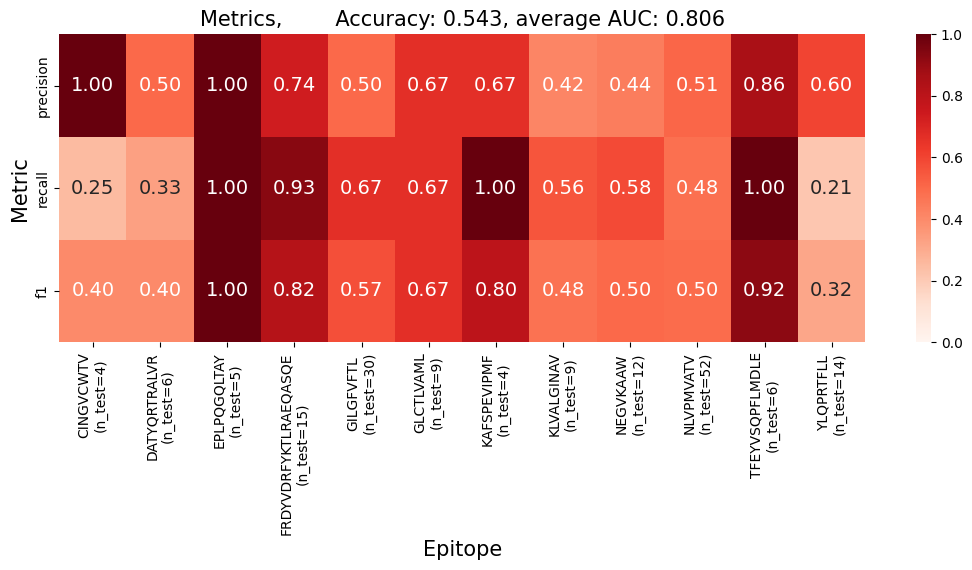

In [123]:
plt.figure(figsize=(13,4))
ax = sns.heatmap(metrics_df, annot=True, cmap='Reds', fmt='.2f', annot_kws={"size": 14}, vmin=0, vmax=1)
ax.set_ylabel('Metric', fontsize=15)
ax.set_xlabel('Epitope', fontsize=15)
ax.set_title(f"Metrics,        Accuracy: {metrics['accuracy']:.3f}, average AUC: {metrics['roc_auc']:.3f}", fontsize=15)
_ = ax.set_xticklabels([epi + f'\n(n_test={(Y_test==epi).sum()})' for epi in metrics_df.columns])

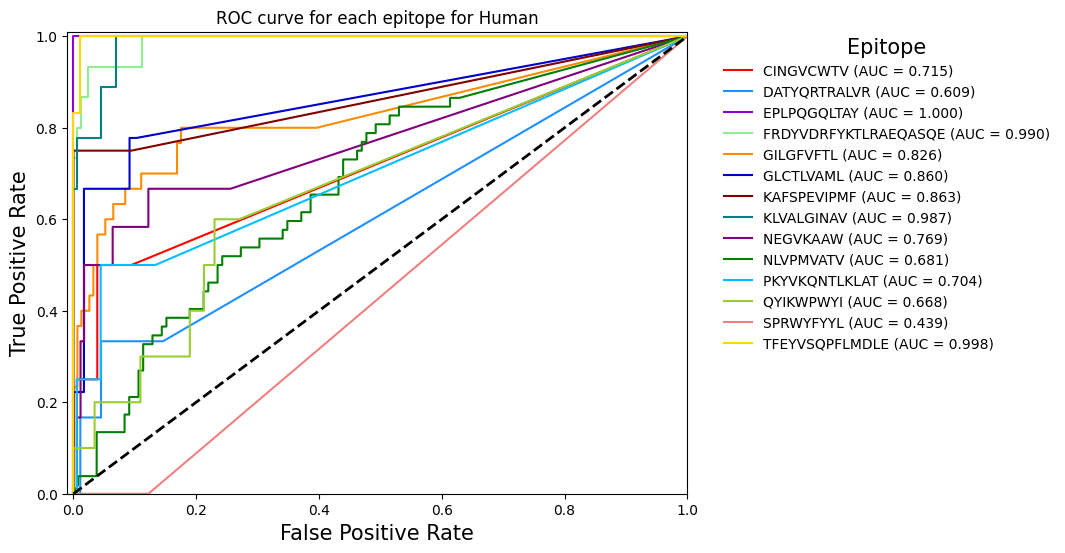

In [76]:
from tcrdist.repertoire import TCRrep
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
Y_matrix = pd.get_dummies(tcrrep_test.clone_df['epitope'])
colors = ['red', 'dodgerblue', 'darkviolet', 'lightgreen', 'darkorange', 'mediumblue', 'maroon', 'teal', 'purple', 'green', 'deepskyblue', 'yellowgreen', 'lightcoral', 'gold', ]
# Get ROC curve info for each epitope
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, ep in enumerate(model.classes_):
    fpr[ep], tpr[ep], _ = roc_curve(Y_matrix.loc[:, ep], preds_prob[:, i])
    roc_auc[ep] = auc(fpr[ep], tpr[ep])

# Plot ROC curves
fig, ax = plt.subplots(figsize=(8, 6))
for ep, color in zip(model.classes_, colors):
    ax.plot(fpr[ep], tpr[ep], color=color, lw=1.5, label=f'{ep} (AUC = {roc_auc[ep]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC curve for each epitope for Human')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False, title='Epitope')
_ = plt.setp(ax.get_legend().get_title(), fontsize=15)
plt.savefig('roc_curve_human.png')
plt.show()

human beta

In [124]:
new_data=pd.read_csv('human_beta.csv')
train_df, test_df = train_test_split(new_data, test_size=0.2,stratify=new_data['epitope'], random_state=20)

# 保存到CSV
train_df.to_csv('train_human.csv', index=False)
test_df.to_csv('test_human.csv', index=False)


In [125]:
##train tr
df_train = pd.read_csv('train_human.csv')

tr = TCRrep(cell_df=df_train,
            chains = ['beta'],
            organism='human',
            deduplicate=True)

X = pd.DataFrame(tr.pw_beta )
Y = tr.clone_df['epitope']

D:\conda\Lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
D:\conda\Lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


In [126]:
# dfs for storing metrics 
metrics_cv_df = pd.DataFrame(columns=['AUC', 'Accuracy', 'Recall', 'Precision'])
auc_cv_df = pd.DataFrame(columns=Y.unique())
recall_cv_df = pd.DataFrame(columns=Y.unique())
precision_cv_df = pd.DataFrame(columns=Y.unique())


# df for storing predictions (for confusion matrix)
preds_df = pd.DataFrame(columns=['y_true', 'y_pred'], index=Y.index)       
#确定k
k_cv=5
best_value=0
metrics = []
kfolds = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=20)
kfolds.get_n_splits(X)
for k_neighbours  in range(1,10) :
    for train_ind, test_ind in kfolds.split(X, Y):
        # split data
        X_train, X_test = X.iloc[train_ind, train_ind], X.iloc[test_ind, train_ind]
        Y_train, Y_test = Y.iloc[train_ind], Y.iloc[test_ind]

        # train model
        model = KNeighborsClassifier(n_neighbors=k_neighbours, metric='precomputed', weights='distance') 
        model.fit(X_train, Y_train.ravel())

        # get predictions
        preds_labels = model.predict(X_test)
        preds_prob = model.predict_proba(X_test)

        # store in df
        preds_df.loc[Y_test.index, 'y_true'] = Y_test.loc[Y_test.index].values
        preds_df.loc[Y_test.index, 'y_pred'] = preds_labels

        ###--- calculate performance metrics

        # calculate & store average metrics
        Y_test_matrix = OneHotEncoder(categories=[model.classes_]).fit_transform(Y_test.values.reshape(-1, 1)).toarray()

        roc_auc_fold = roc_auc_score(Y_test_matrix, preds_prob, multi_class='ovr', average='macro')
        accuracy_fold = accuracy_score(Y_test, preds_labels)
        precision_fold = precision_score(Y_test, preds_labels, average='macro') # macro - simplest, unweighted mean between all classes
        recall_fold = recall_score(Y_test, preds_labels, average='macro') # macro - simplest, unweighted mean between all classes

        metrics.append(pd.Series({'AUC': roc_auc_fold, 'Accuracy': accuracy_fold, 
                                                        'Recall': recall_fold, 'Precision': precision_fold}))
    metric_df = pd.DataFrame(metrics)
    average_df= metric_df.mean()
    if best_value < average_df['Accuracy']:
        best_value = average_df['Accuracy']
        best_k = k_neighbours
    metrics = []

print(best_k)

7


In [127]:
k_neighbours=7

In [128]:
# train model on entire train set
Y_binarized = label_binarize(Y, classes=np.unique(Y))
model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=k_neighbours, metric='precomputed', weights='distance'))
model.fit(X, Y.values.ravel())

OneVsRestClassifier(estimator=KNeighborsClassifier(metric='precomputed',
                                                   n_neighbors=7,
                                                   weights='distance'))

In [129]:
# 获取测试 TCR 和训练 TCR 之间的 tcrdist 距离
df_test= pd.read_csv('test_human.csv')
tcrrep_test = TCRrep(cell_df=df_test,
                     organism='human',
                     chains=['beta'],
                     deduplicate=True)

tcrrep_test.compute_rect_distances(df=tcrrep_test.clone_df,
                                    df2=tr.clone_df)

X_test = pd.DataFrame(tcrrep_test.rw_beta )
# get predictions
preds_prob = model.predict_proba(X_test)
preds_labels = model.predict(X_test)
# get test data labels
Y_test = tcrrep_test.clone_df['epitope']

D:\conda\Lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
D:\conda\Lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


In [130]:
#Calculate performance metrics
metrics = {}
metrics['accuracy'] = accuracy_score(Y_test, preds_labels)
metrics['roc_auc'] = roc_auc_score(Y_test, pd.DataFrame(preds_prob, columns=model.classes_), average='macro', multi_class='ovr')

metrics['confusion_matrix'] = pd.DataFrame(confusion_matrix(Y_test, preds_labels), columns=model.classes_, index=model.classes_)
metrics['confusion_matrix_norm'] = pd.DataFrame(confusion_matrix(Y_test, preds_labels, normalize='true'), columns=model.classes_, index=model.classes_)

metrics_df = pd.DataFrame(columns=model.classes_)
metrics_df.loc['precision'] = precision_score(Y_test, preds_labels, average=None)
metrics_df.loc['recall'] = recall_score(Y_test, preds_labels, average=None)
metrics_df.loc['f1'] = f1_score(Y_test, preds_labels, average=None)

In [131]:
print(metrics['accuracy'])
print(metrics['roc_auc'])

0.49206349206349204
0.7945163422753233


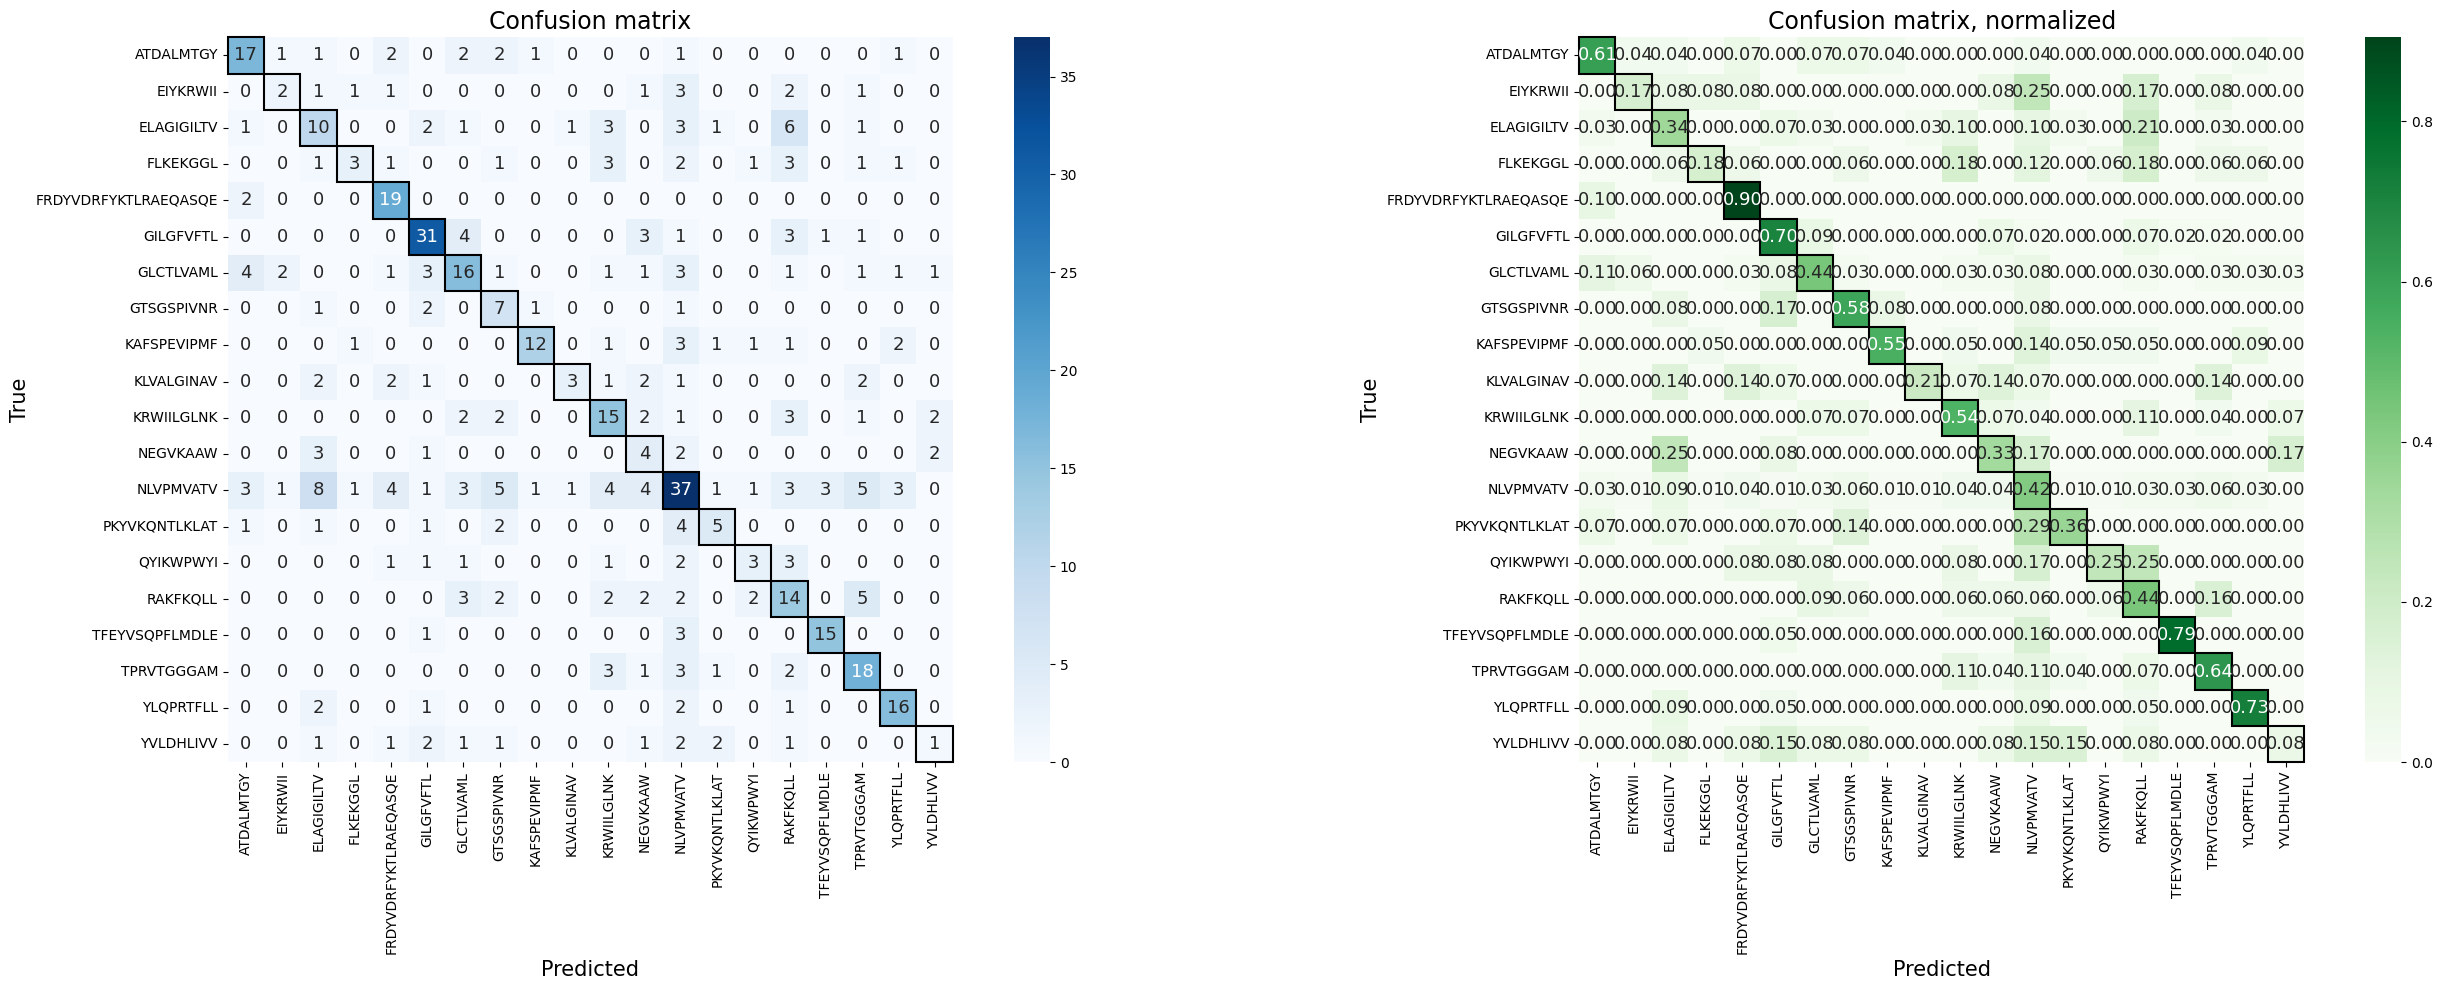

In [135]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28,10))
sns.set_context(font_scale=1.1)
sns.heatmap(metrics['confusion_matrix'], annot=True, cmap='Blues', fmt='', ax=axes[0], square=True, annot_kws={"size": 13})
axes[0].set_xlabel('Predicted', fontsize=15)
axes[0].set_ylabel('True', fontsize=15)
axes[0].set_title('Confusion matrix', fontsize=17)
for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)

sns.heatmap(metrics['confusion_matrix_norm'], annot=True, cmap='Greens', fmt='.2f', ax=axes[1], square=True, annot_kws={"size": 13})
axes[1].set_title('Confusion matrix, normalized', fontsize=17)
axes[1].set_xlabel('Predicted', fontsize=15)
axes[1].set_ylabel('True', fontsize=15)
for tick in axes[1].get_xticklabels():
        tick.set_rotation(90)

for epi_ind in range(metrics['confusion_matrix'].shape[0]):
    axes[0].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))
    axes[1].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))

plt.tight_layout()

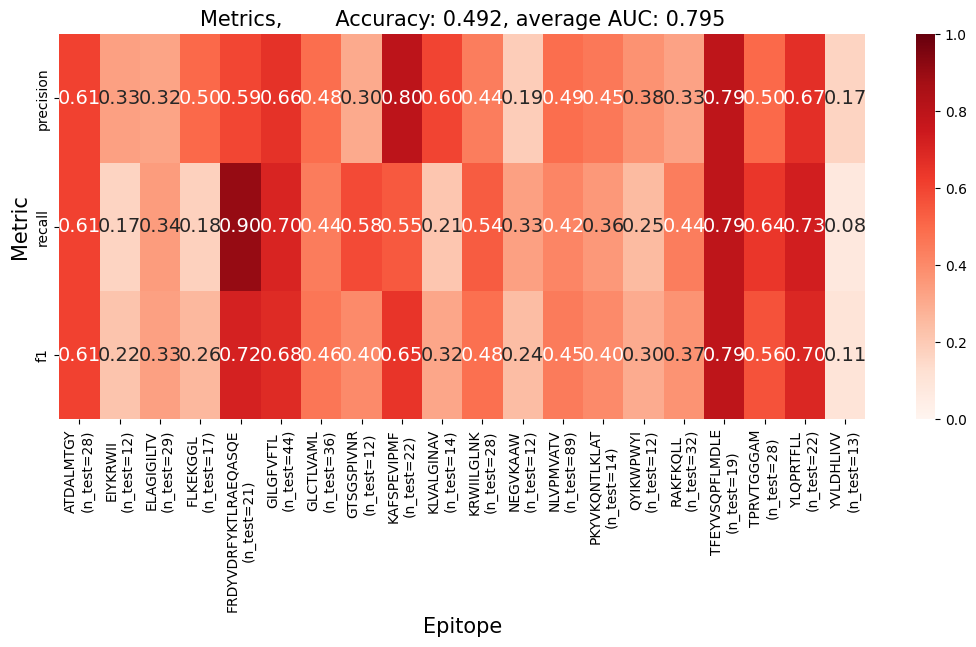

In [136]:
plt.figure(figsize=(13,5))
ax = sns.heatmap(metrics_df, annot=True, cmap='Reds', fmt='.2f', annot_kws={"size": 14}, vmin=0, vmax=1)
ax.set_ylabel('Metric', fontsize=15)
ax.set_xlabel('Epitope', fontsize=15)
ax.set_title(f"Metrics,        Accuracy: {metrics['accuracy']:.3f}, average AUC: {metrics['roc_auc']:.3f}", fontsize=15)
_ = ax.set_xticklabels([epi + f'\n(n_test={(Y_test==epi).sum()})' for epi in metrics_df.columns])

mouse combined

In [137]:
new_data=pd.read_csv('mouse_combined.csv')
train_df, test_df = train_test_split(new_data, test_size=0.2,stratify=new_data['epitope'], random_state=20)

# 保存到CSV
train_df.to_csv('train_mouse.csv', index=False)
test_df.to_csv('test_mouse.csv', index=False)


In [139]:
##train tr
df_train = pd.read_csv('train_mouse.csv')

tr = TCRrep(cell_df=df_train,
            chains = ['alpha','beta'],
            organism='mouse',
            deduplicate=True)

X = pd.DataFrame(tr.pw_alpha + tr.pw_beta)
Y = tr.clone_df['epitope']

D:\conda\Lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
D:\conda\Lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


In [140]:
# dfs for storing metrics 
metrics_cv_df = pd.DataFrame(columns=['AUC', 'Accuracy', 'Recall', 'Precision'])
auc_cv_df = pd.DataFrame(columns=Y.unique())
recall_cv_df = pd.DataFrame(columns=Y.unique())
precision_cv_df = pd.DataFrame(columns=Y.unique())


# df for storing predictions (for confusion matrix)
preds_df = pd.DataFrame(columns=['y_true', 'y_pred'], index=Y.index)       
#确定k
k_cv=5
best_value=0
metrics = []
kfolds = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=20)
kfolds.get_n_splits(X)
for k_neighbours  in range(1,10) :
    for train_ind, test_ind in kfolds.split(X, Y):
        # split data
        X_train, X_test = X.iloc[train_ind, train_ind], X.iloc[test_ind, train_ind]
        Y_train, Y_test = Y.iloc[train_ind], Y.iloc[test_ind]

        # train model
        model = KNeighborsClassifier(n_neighbors=k_neighbours, metric='precomputed', weights='distance') 
        model.fit(X_train, Y_train.ravel())

        # get predictions
        preds_labels = model.predict(X_test)
        preds_prob = model.predict_proba(X_test)

        # store in df
        preds_df.loc[Y_test.index, 'y_true'] = Y_test.loc[Y_test.index].values
        preds_df.loc[Y_test.index, 'y_pred'] = preds_labels

        ###--- calculate performance metrics

        # calculate & store average metrics
        Y_test_matrix = OneHotEncoder(categories=[model.classes_]).fit_transform(Y_test.values.reshape(-1, 1)).toarray()

        roc_auc_fold = roc_auc_score(Y_test_matrix, preds_prob, multi_class='ovr', average='macro')
        accuracy_fold = accuracy_score(Y_test, preds_labels)
        precision_fold = precision_score(Y_test, preds_labels, average='macro') # macro - simplest, unweighted mean between all classes
        recall_fold = recall_score(Y_test, preds_labels, average='macro') # macro - simplest, unweighted mean between all classes

        metrics.append(pd.Series({'AUC': roc_auc_fold, 'Accuracy': accuracy_fold, 
                                                        'Recall': recall_fold, 'Precision': precision_fold}))
    metric_df = pd.DataFrame(metrics)
    average_df= metric_df.mean()
    if best_value < average_df['AUC']+average_df['Accuracy']+average_df['Recall']+average_df['Precision'] :
        best_value = average_df['AUC']+average_df['Accuracy']+average_df['Recall']+average_df['Precision']
        best_k = k_neighbours
    metrics = []

print(best_k)

5


In [141]:
k_neighbours=5


0.917857046808677

In [142]:
# train model on entire train set
Y_binarized = label_binarize(Y, classes=np.unique(Y))
model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=k_neighbours, metric='precomputed', weights='distance'))
model.fit(X, Y.values.ravel())

OneVsRestClassifier(estimator=KNeighborsClassifier(metric='precomputed',
                                                   weights='distance'))

In [144]:
# 获取测试 TCR 和训练 TCR 之间的 tcrdist 距离
df_test= pd.read_csv('test_mouse.csv')
tcrrep_test = TCRrep(cell_df=df_test,
                     organism='mouse',
                     chains=['alpha','beta'],
                     deduplicate=True)

tcrrep_test.compute_rect_distances(df=tcrrep_test.clone_df,
                                    df2=tr.clone_df)

X_test = pd.DataFrame(tcrrep_test.rw_alpha + tcrrep_test.rw_beta)
# get predictions
preds_prob = model.predict_proba(X_test)
preds_labels = model.predict(X_test)
# get test data labels
Y_test = tcrrep_test.clone_df['epitope']

D:\conda\Lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
D:\conda\Lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


In [145]:
#Calculate performance metrics
metrics = {}
metrics['accuracy'] = accuracy_score(Y_test, preds_labels)
metrics['roc_auc'] = roc_auc_score(Y_test, pd.DataFrame(preds_prob, columns=model.classes_), average='macro', multi_class='ovr')

metrics['confusion_matrix'] = pd.DataFrame(confusion_matrix(Y_test, preds_labels), columns=model.classes_, index=model.classes_)
metrics['confusion_matrix_norm'] = pd.DataFrame(confusion_matrix(Y_test, preds_labels, normalize='true'), columns=model.classes_, index=model.classes_)

metrics_df = pd.DataFrame(columns=model.classes_)
metrics_df.loc['precision'] = precision_score(Y_test, preds_labels, average=None)
metrics_df.loc['recall'] = recall_score(Y_test, preds_labels, average=None)
metrics_df.loc['f1'] = f1_score(Y_test, preds_labels, average=None)

In [146]:
print(metrics['accuracy'])
print(metrics['roc_auc'])

0.782312925170068
0.8980275435340543


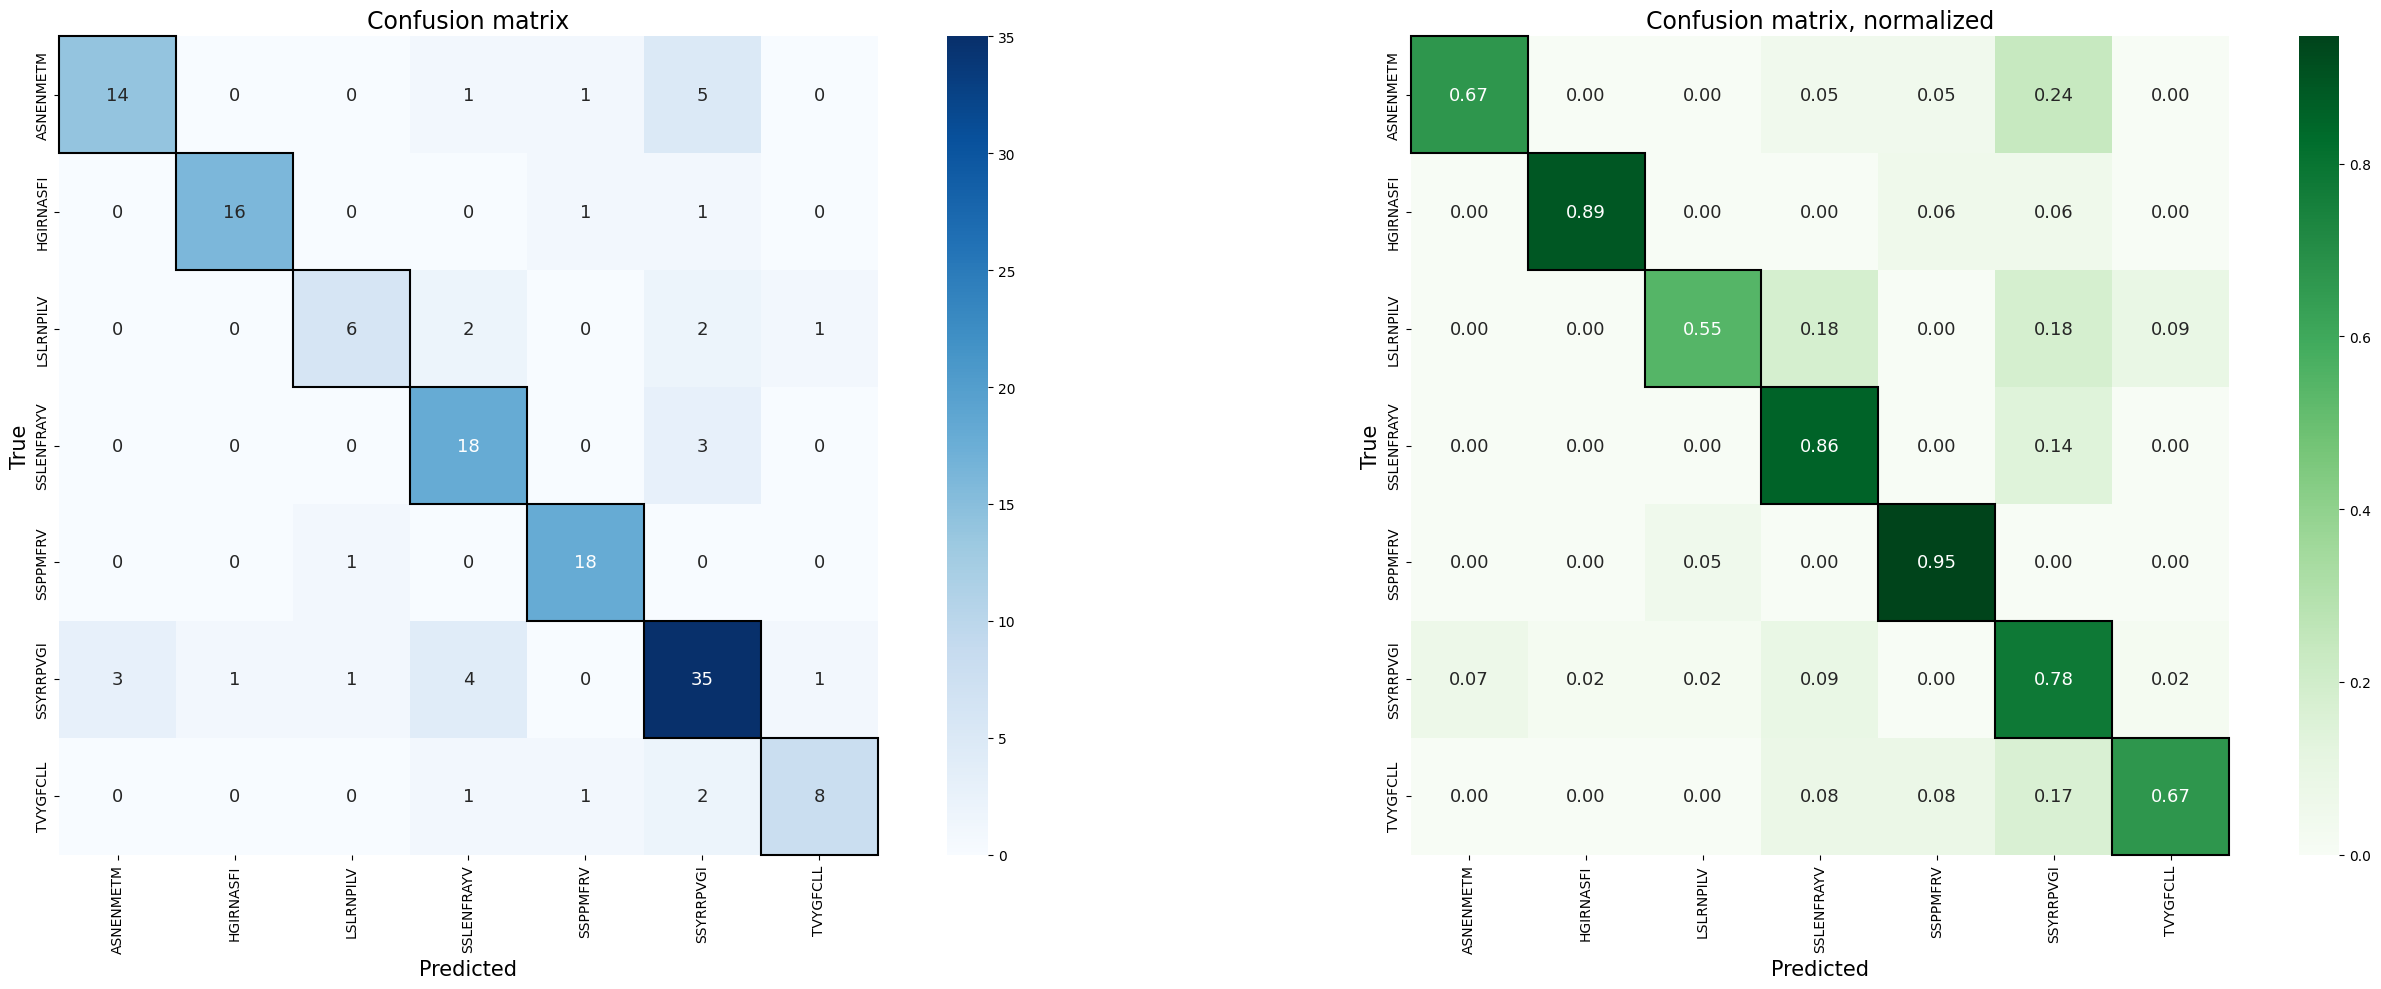

In [147]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28,10))
sns.set_context(font_scale=1.1)
sns.heatmap(metrics['confusion_matrix'], annot=True, cmap='Blues', fmt='', ax=axes[0], square=True, annot_kws={"size": 13})
axes[0].set_xlabel('Predicted', fontsize=15)
axes[0].set_ylabel('True', fontsize=15)
axes[0].set_title('Confusion matrix', fontsize=17)
for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)

sns.heatmap(metrics['confusion_matrix_norm'], annot=True, cmap='Greens', fmt='.2f', ax=axes[1], square=True, annot_kws={"size": 13})
axes[1].set_title('Confusion matrix, normalized', fontsize=17)
axes[1].set_xlabel('Predicted', fontsize=15)
axes[1].set_ylabel('True', fontsize=15)
for tick in axes[1].get_xticklabels():
        tick.set_rotation(90)

for epi_ind in range(metrics['confusion_matrix'].shape[0]):
    axes[0].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))
    axes[1].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))

plt.tight_layout()

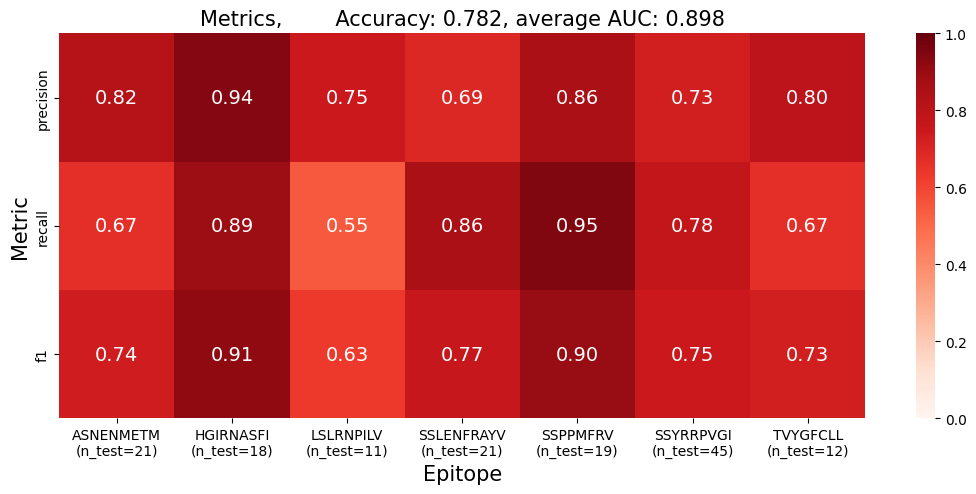

In [148]:
plt.figure(figsize=(13,5))
ax = sns.heatmap(metrics_df, annot=True, cmap='Reds', fmt='.2f', annot_kws={"size": 14}, vmin=0, vmax=1)
ax.set_ylabel('Metric', fontsize=15)
ax.set_xlabel('Epitope', fontsize=15)
ax.set_title(f"Metrics,        Accuracy: {metrics['accuracy']:.3f}, average AUC: {metrics['roc_auc']:.3f}", fontsize=15)
_ = ax.set_xticklabels([epi + f'\n(n_test={(Y_test==epi).sum()})' for epi in metrics_df.columns])

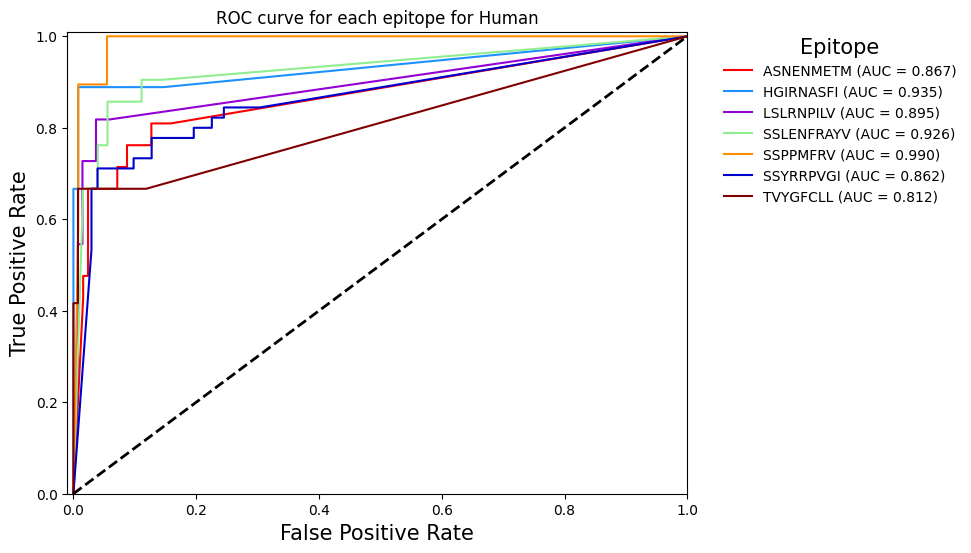

In [149]:
from tcrdist.repertoire import TCRrep
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
Y_matrix = pd.get_dummies(tcrrep_test.clone_df['epitope'])
colors = ['red', 'dodgerblue', 'darkviolet', 'lightgreen', 'darkorange', 'mediumblue', 'maroon', 'teal', 'purple', 'green', 'deepskyblue', 'yellowgreen', 'lightcoral', 'gold', ]
# Get ROC curve info for each epitope
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, ep in enumerate(model.classes_):
    fpr[ep], tpr[ep], _ = roc_curve(Y_matrix.loc[:, ep], preds_prob[:, i])
    roc_auc[ep] = auc(fpr[ep], tpr[ep])

# Plot ROC curves
fig, ax = plt.subplots(figsize=(8, 6))
for ep, color in zip(model.classes_, colors):
    ax.plot(fpr[ep], tpr[ep], color=color, lw=1.5, label=f'{ep} (AUC = {roc_auc[ep]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC curve for each epitope for Human')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False, title='Epitope')
_ = plt.setp(ax.get_legend().get_title(), fontsize=15)
plt.savefig('roc_curve_human.png')
plt.show()

In [150]:
new_data=pd.read_csv('mouse_alpha.csv')
train_df, test_df = train_test_split(new_data, test_size=0.2,stratify=new_data['epitope'], random_state=20)

# 保存到CSV
train_df.to_csv('train_mouse.csv', index=False)
test_df.to_csv('test_mouse.csv', index=False)

In [151]:
##train tr
df_train = pd.read_csv('train_mouse.csv')

tr = TCRrep(cell_df=df_train,
            chains = ['alpha'],
            organism='mouse',
            deduplicate=True)

X = pd.DataFrame(tr.pw_alpha)
Y = tr.clone_df['epitope']

D:\conda\Lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
D:\conda\Lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


In [152]:
# dfs for storing metrics 
metrics_cv_df = pd.DataFrame(columns=['AUC', 'Accuracy', 'Recall', 'Precision'])
auc_cv_df = pd.DataFrame(columns=Y.unique())
recall_cv_df = pd.DataFrame(columns=Y.unique())
precision_cv_df = pd.DataFrame(columns=Y.unique())


# df for storing predictions (for confusion matrix)
preds_df = pd.DataFrame(columns=['y_true', 'y_pred'], index=Y.index)       
#确定k
k_cv=5
best_value=0
metrics = []
kfolds = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=20)
kfolds.get_n_splits(X)
for k_neighbours  in range(1,10) :
    for train_ind, test_ind in kfolds.split(X, Y):
        # split data
        X_train, X_test = X.iloc[train_ind, train_ind], X.iloc[test_ind, train_ind]
        Y_train, Y_test = Y.iloc[train_ind], Y.iloc[test_ind]

        # train model
        model = KNeighborsClassifier(n_neighbors=k_neighbours, metric='precomputed', weights='distance') 
        model.fit(X_train, Y_train.ravel())

        # get predictions
        preds_labels = model.predict(X_test)
        preds_prob = model.predict_proba(X_test)

        # store in df
        preds_df.loc[Y_test.index, 'y_true'] = Y_test.loc[Y_test.index].values
        preds_df.loc[Y_test.index, 'y_pred'] = preds_labels

        ###--- calculate performance metrics

        # calculate & store average metrics
        Y_test_matrix = OneHotEncoder(categories=[model.classes_]).fit_transform(Y_test.values.reshape(-1, 1)).toarray()

        roc_auc_fold = roc_auc_score(Y_test_matrix, preds_prob, multi_class='ovr', average='macro')
        accuracy_fold = accuracy_score(Y_test, preds_labels)
        precision_fold = precision_score(Y_test, preds_labels, average='macro') # macro - simplest, unweighted mean between all classes
        recall_fold = recall_score(Y_test, preds_labels, average='macro') # macro - simplest, unweighted mean between all classes

        metrics.append(pd.Series({'AUC': roc_auc_fold, 'Accuracy': accuracy_fold, 
                                                        'Recall': recall_fold, 'Precision': precision_fold}))
    metric_df = pd.DataFrame(metrics)
    average_df= metric_df.mean()
    if best_value < average_df['AUC']+average_df['Accuracy']+average_df['Recall']+average_df['Precision'] :
        best_value = average_df['AUC']+average_df['Accuracy']+average_df['Recall']+average_df['Precision']
        best_k = k_neighbours
    metrics = []

print(best_k)

D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in l

6


D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [153]:
k_neighbours=6

In [154]:
# train model on entire train set
Y_binarized = label_binarize(Y, classes=np.unique(Y))
model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=k_neighbours, metric='precomputed', weights='distance'))
model.fit(X, Y.values.ravel())

OneVsRestClassifier(estimator=KNeighborsClassifier(metric='precomputed',
                                                   n_neighbors=6,
                                                   weights='distance'))

In [156]:
# 获取测试 TCR 和训练 TCR 之间的 tcrdist 距离
df_test= pd.read_csv('test_mouse.csv')
tcrrep_test = TCRrep(cell_df=df_test,
                     organism='mouse',
                     chains=['alpha'],
                     deduplicate=True)

tcrrep_test.compute_rect_distances(df=tcrrep_test.clone_df,
                                    df2=tr.clone_df)

X_test = pd.DataFrame(tcrrep_test.rw_alpha )
# get predictions
preds_prob = model.predict_proba(X_test)
preds_labels = model.predict(X_test)
# get test data labels
Y_test = tcrrep_test.clone_df['epitope']

D:\conda\Lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
D:\conda\Lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


In [157]:
#Calculate performance metrics
metrics = {}
metrics['accuracy'] = accuracy_score(Y_test, preds_labels)
metrics['roc_auc'] = roc_auc_score(Y_test, pd.DataFrame(preds_prob, columns=model.classes_), average='macro', multi_class='ovr')

metrics['confusion_matrix'] = pd.DataFrame(confusion_matrix(Y_test, preds_labels), columns=model.classes_, index=model.classes_)
metrics['confusion_matrix_norm'] = pd.DataFrame(confusion_matrix(Y_test, preds_labels, normalize='true'), columns=model.classes_, index=model.classes_)

metrics_df = pd.DataFrame(columns=model.classes_)
metrics_df.loc['precision'] = precision_score(Y_test, preds_labels, average=None)
metrics_df.loc['recall'] = recall_score(Y_test, preds_labels, average=None)
metrics_df.loc['f1'] = f1_score(Y_test, preds_labels, average=None)

In [158]:
print(metrics['accuracy'])
print(metrics['roc_auc'])

0.5213675213675214
0.7499825309522148


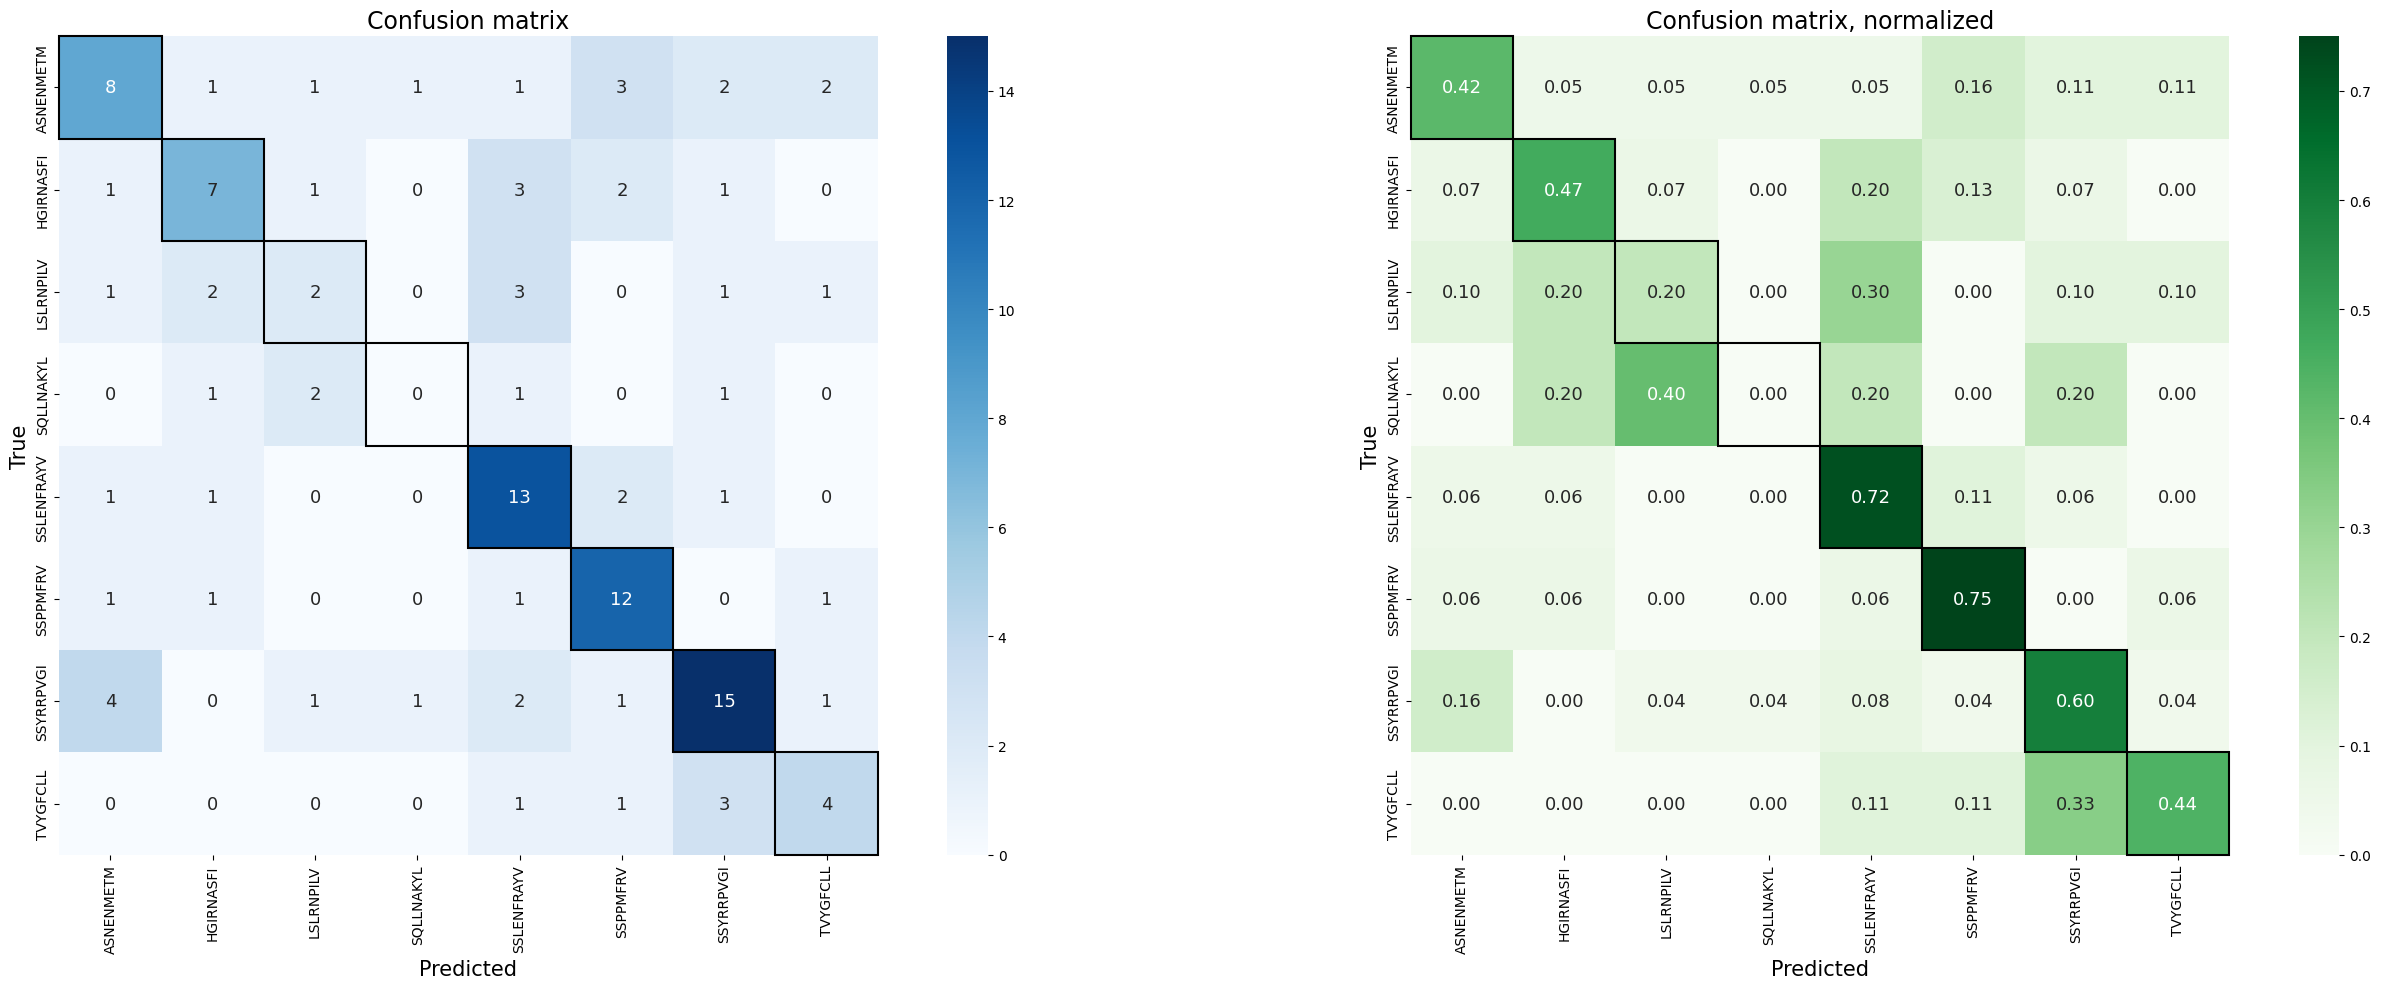

In [159]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28,10))
sns.set_context(font_scale=1.1)
sns.heatmap(metrics['confusion_matrix'], annot=True, cmap='Blues', fmt='', ax=axes[0], square=True, annot_kws={"size": 13})
axes[0].set_xlabel('Predicted', fontsize=15)
axes[0].set_ylabel('True', fontsize=15)
axes[0].set_title('Confusion matrix', fontsize=17)
for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)

sns.heatmap(metrics['confusion_matrix_norm'], annot=True, cmap='Greens', fmt='.2f', ax=axes[1], square=True, annot_kws={"size": 13})
axes[1].set_title('Confusion matrix, normalized', fontsize=17)
axes[1].set_xlabel('Predicted', fontsize=15)
axes[1].set_ylabel('True', fontsize=15)
for tick in axes[1].get_xticklabels():
        tick.set_rotation(90)

for epi_ind in range(metrics['confusion_matrix'].shape[0]):
    axes[0].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))
    axes[1].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))

plt.tight_layout()

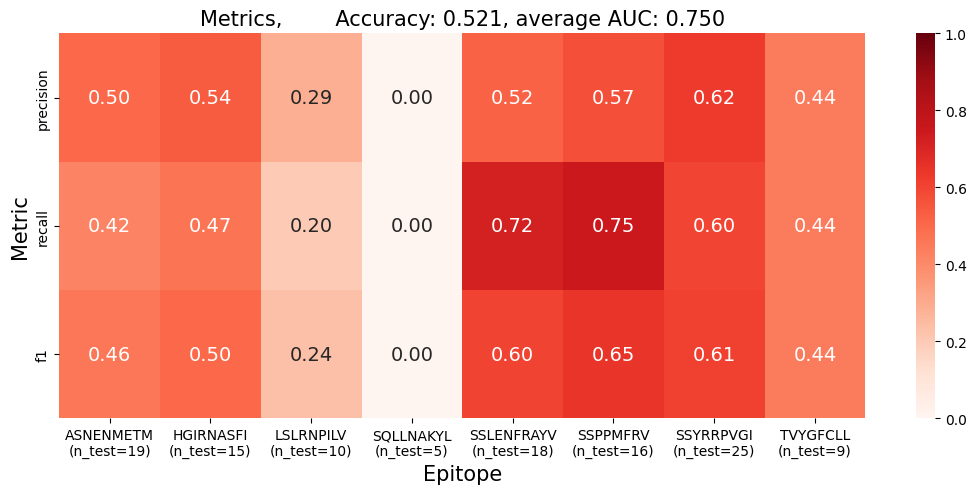

In [160]:
plt.figure(figsize=(13,5))
ax = sns.heatmap(metrics_df, annot=True, cmap='Reds', fmt='.2f', annot_kws={"size": 14}, vmin=0, vmax=1)
ax.set_ylabel('Metric', fontsize=15)
ax.set_xlabel('Epitope', fontsize=15)
ax.set_title(f"Metrics,        Accuracy: {metrics['accuracy']:.3f}, average AUC: {metrics['roc_auc']:.3f}", fontsize=15)
_ = ax.set_xticklabels([epi + f'\n(n_test={(Y_test==epi).sum()})' for epi in metrics_df.columns])

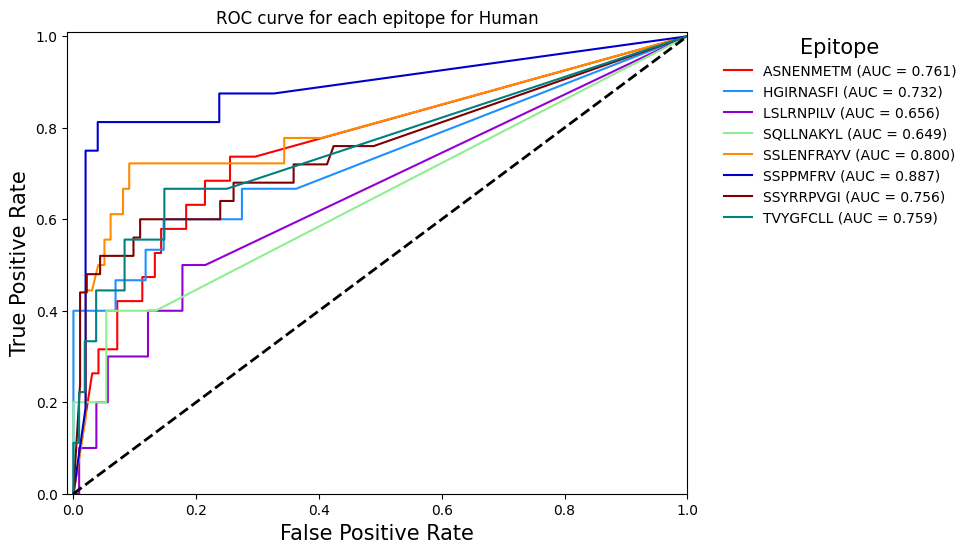

In [161]:
from tcrdist.repertoire import TCRrep
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
Y_matrix = pd.get_dummies(tcrrep_test.clone_df['epitope'])
colors = ['red', 'dodgerblue', 'darkviolet', 'lightgreen', 'darkorange', 'mediumblue', 'maroon', 'teal', 'purple', 'green', 'deepskyblue', 'yellowgreen', 'lightcoral', 'gold', ]
# Get ROC curve info for each epitope
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, ep in enumerate(model.classes_):
    fpr[ep], tpr[ep], _ = roc_curve(Y_matrix.loc[:, ep], preds_prob[:, i])
    roc_auc[ep] = auc(fpr[ep], tpr[ep])

# Plot ROC curves
fig, ax = plt.subplots(figsize=(8, 6))
for ep, color in zip(model.classes_, colors):
    ax.plot(fpr[ep], tpr[ep], color=color, lw=1.5, label=f'{ep} (AUC = {roc_auc[ep]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC curve for each epitope for Human')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False, title='Epitope')
_ = plt.setp(ax.get_legend().get_title(), fontsize=15)
plt.savefig('roc_curve_human.png')
plt.show()

In [163]:
new_data=pd.read_csv('mouse_beta.csv')
train_df, test_df = train_test_split(new_data, test_size=0.2,stratify=new_data['epitope'], random_state=58)

# 保存到CSV
train_df.to_csv('train_mouse.csv', index=False)
test_df.to_csv('test_mouse.csv', index=False)

In [165]:
##train tr
df_train = pd.read_csv('train_mouse.csv')

tr = TCRrep(cell_df=df_train,
            chains = ['beta'],
            organism='mouse',
            deduplicate=True)

X = pd.DataFrame(tr.pw_beta)
Y = tr.clone_df['epitope']

D:\conda\Lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
D:\conda\Lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


In [167]:
# dfs for storing metrics 
metrics_cv_df = pd.DataFrame(columns=['AUC', 'Accuracy', 'Recall', 'Precision'])
auc_cv_df = pd.DataFrame(columns=Y.unique())
recall_cv_df = pd.DataFrame(columns=Y.unique())
precision_cv_df = pd.DataFrame(columns=Y.unique())


# df for storing predictions (for confusion matrix)
preds_df = pd.DataFrame(columns=['y_true', 'y_pred'], index=Y.index)       
#确定k
k_cv=5
best_value=0
metrics = []
kfolds = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=20)
kfolds.get_n_splits(X)
for k_neighbours  in range(1,20) :
    for train_ind, test_ind in kfolds.split(X, Y):
        # split data
        X_train, X_test = X.iloc[train_ind, train_ind], X.iloc[test_ind, train_ind]
        Y_train, Y_test = Y.iloc[train_ind], Y.iloc[test_ind]

        # train model
        model = KNeighborsClassifier(n_neighbors=k_neighbours, metric='precomputed', weights='distance') 
        model.fit(X_train, Y_train.ravel())

        # get predictions
        preds_labels = model.predict(X_test)
        preds_prob = model.predict_proba(X_test)

        # store in df
        preds_df.loc[Y_test.index, 'y_true'] = Y_test.loc[Y_test.index].values
        preds_df.loc[Y_test.index, 'y_pred'] = preds_labels

        ###--- calculate performance metrics

        # calculate & store average metrics
        Y_test_matrix = OneHotEncoder(categories=[model.classes_]).fit_transform(Y_test.values.reshape(-1, 1)).toarray()

        roc_auc_fold = roc_auc_score(Y_test_matrix, preds_prob, multi_class='ovr', average='macro')
        accuracy_fold = accuracy_score(Y_test, preds_labels)
        precision_fold = precision_score(Y_test, preds_labels, average='macro') # macro - simplest, unweighted mean between all classes
        recall_fold = recall_score(Y_test, preds_labels, average='macro') # macro - simplest, unweighted mean between all classes

        metrics.append(pd.Series({'AUC': roc_auc_fold, 'Accuracy': accuracy_fold, 
                                                        'Recall': recall_fold, 'Precision': precision_fold}))
    metric_df = pd.DataFrame(metrics)
    average_df= metric_df.mean()
    if best_value < average_df['AUC']+average_df['Accuracy']+average_df['Recall']+average_df['Precision'] :
        best_value = average_df['AUC']+average_df['Accuracy']+average_df['Recall']+average_df['Precision']
        best_k = k_neighbours
    metrics = []

print(best_k)

D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9


In [168]:
k_neighbours=9

In [169]:
# train model on entire train set
Y_binarized = label_binarize(Y, classes=np.unique(Y))
model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=k_neighbours, metric='precomputed', weights='distance'))
model.fit(X, Y.values.ravel())

OneVsRestClassifier(estimator=KNeighborsClassifier(metric='precomputed',
                                                   n_neighbors=9,
                                                   weights='distance'))

In [170]:
# 获取测试 TCR 和训练 TCR 之间的 tcrdist 距离
df_test= pd.read_csv('test_mouse.csv')
tcrrep_test = TCRrep(cell_df=df_test,
                     organism='mouse',
                     chains=['beta'],
                     deduplicate=True)

tcrrep_test.compute_rect_distances(df=tcrrep_test.clone_df,
                                    df2=tr.clone_df)

X_test = pd.DataFrame(tcrrep_test.rw_beta)
# get predictions
preds_prob = model.predict_proba(X_test)
preds_labels = model.predict(X_test)
# get test data labels
Y_test = tcrrep_test.clone_df['epitope']

D:\conda\Lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
D:\conda\Lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


In [171]:
#Calculate performance metrics
metrics = {}
metrics['accuracy'] = accuracy_score(Y_test, preds_labels)
metrics['roc_auc'] = roc_auc_score(Y_test, pd.DataFrame(preds_prob, columns=model.classes_), average='macro', multi_class='ovr')

metrics['confusion_matrix'] = pd.DataFrame(confusion_matrix(Y_test, preds_labels), columns=model.classes_, index=model.classes_)
metrics['confusion_matrix_norm'] = pd.DataFrame(confusion_matrix(Y_test, preds_labels, normalize='true'), columns=model.classes_, index=model.classes_)

metrics_df = pd.DataFrame(columns=model.classes_)
metrics_df.loc['precision'] = precision_score(Y_test, preds_labels, average=None)
metrics_df.loc['recall'] = recall_score(Y_test, preds_labels, average=None)
metrics_df.loc['f1'] = f1_score(Y_test, preds_labels, average=None)

D:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [172]:
print(metrics['accuracy'])
print(metrics['roc_auc'])

0.6666666666666666
0.8644904434296452


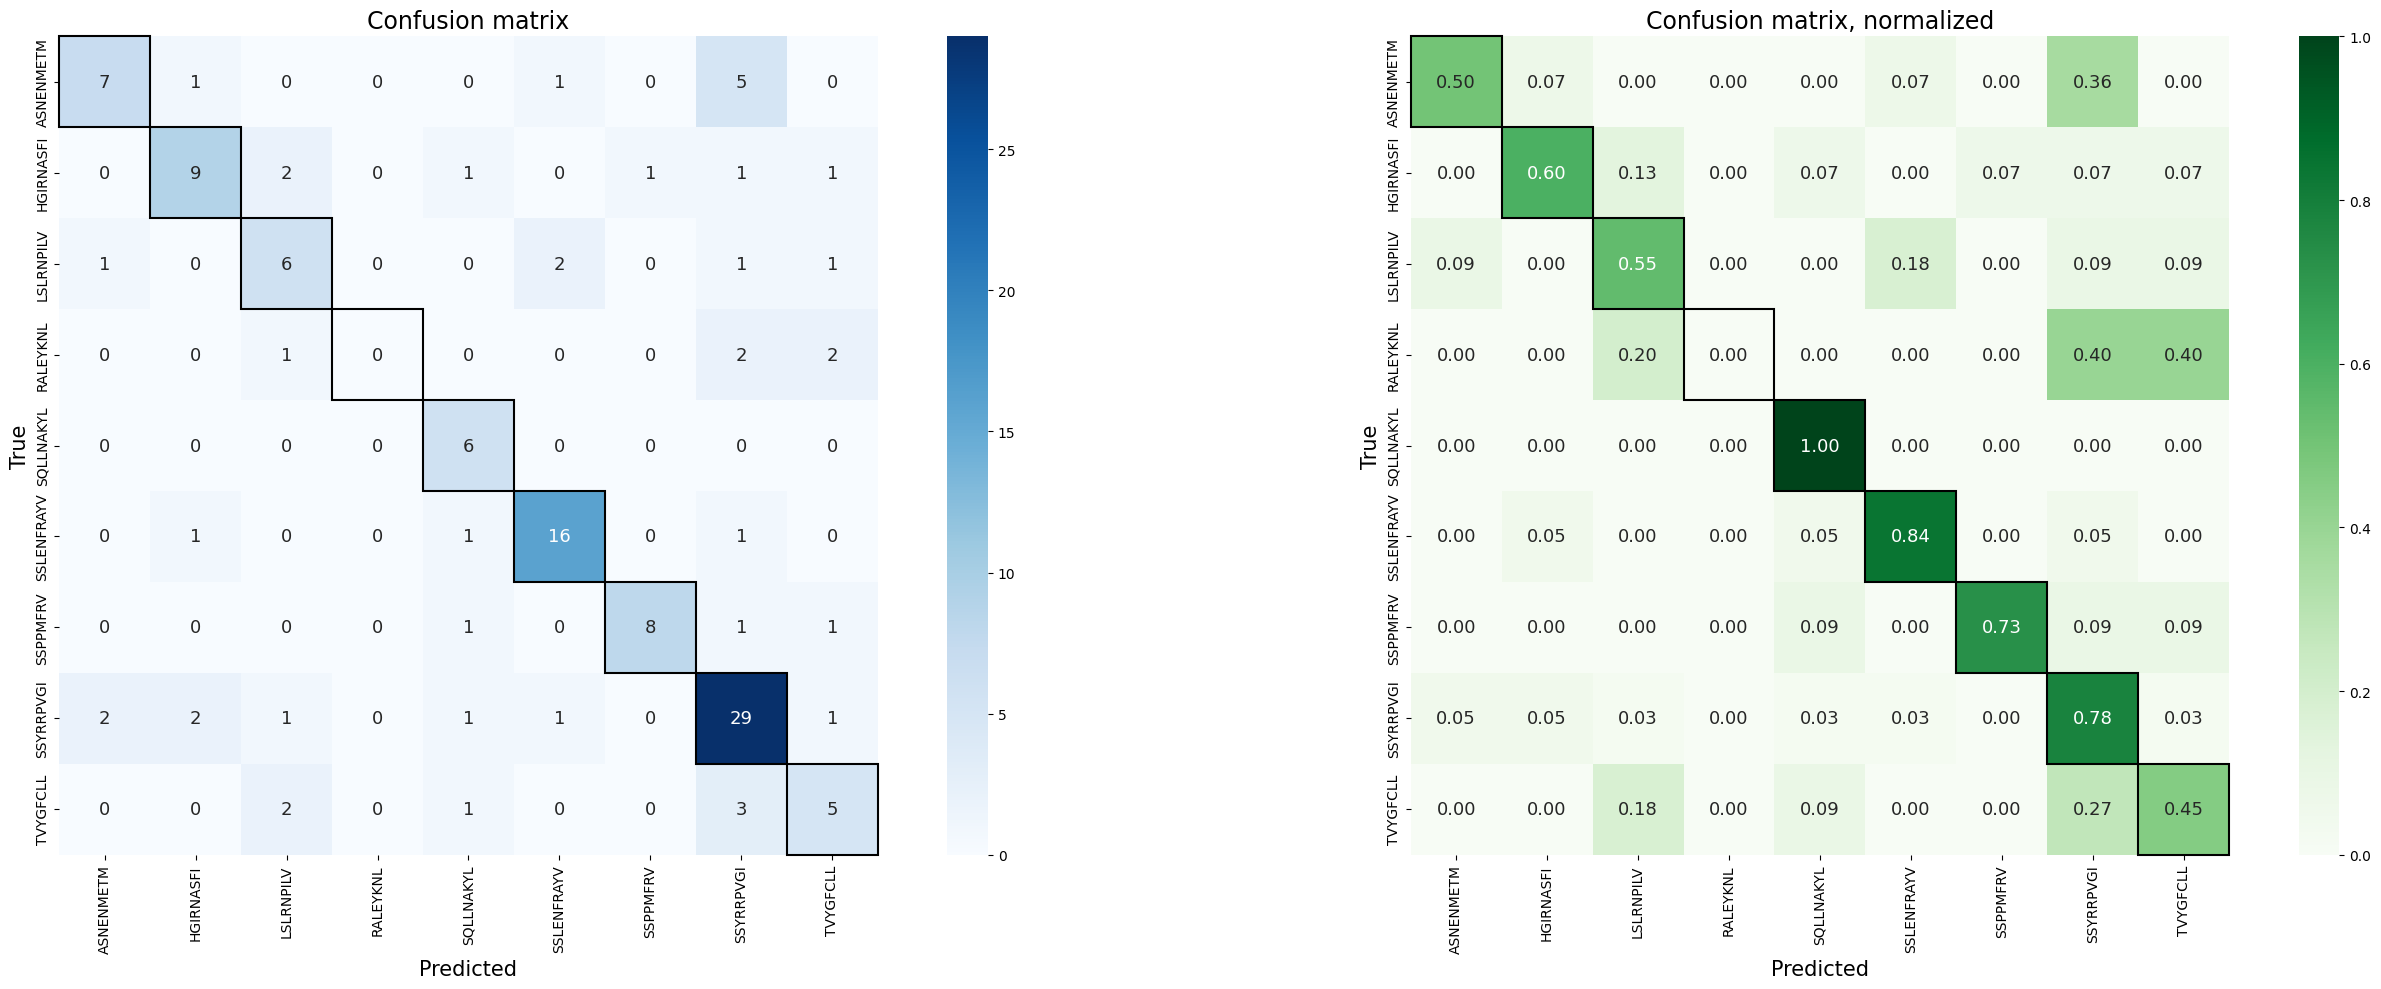

In [173]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28,10))
sns.set_context(font_scale=1.1)
sns.heatmap(metrics['confusion_matrix'], annot=True, cmap='Blues', fmt='', ax=axes[0], square=True, annot_kws={"size": 13})
axes[0].set_xlabel('Predicted', fontsize=15)
axes[0].set_ylabel('True', fontsize=15)
axes[0].set_title('Confusion matrix', fontsize=17)
for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)

sns.heatmap(metrics['confusion_matrix_norm'], annot=True, cmap='Greens', fmt='.2f', ax=axes[1], square=True, annot_kws={"size": 13})
axes[1].set_title('Confusion matrix, normalized', fontsize=17)
axes[1].set_xlabel('Predicted', fontsize=15)
axes[1].set_ylabel('True', fontsize=15)
for tick in axes[1].get_xticklabels():
        tick.set_rotation(90)

for epi_ind in range(metrics['confusion_matrix'].shape[0]):
    axes[0].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))
    axes[1].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))

plt.tight_layout()

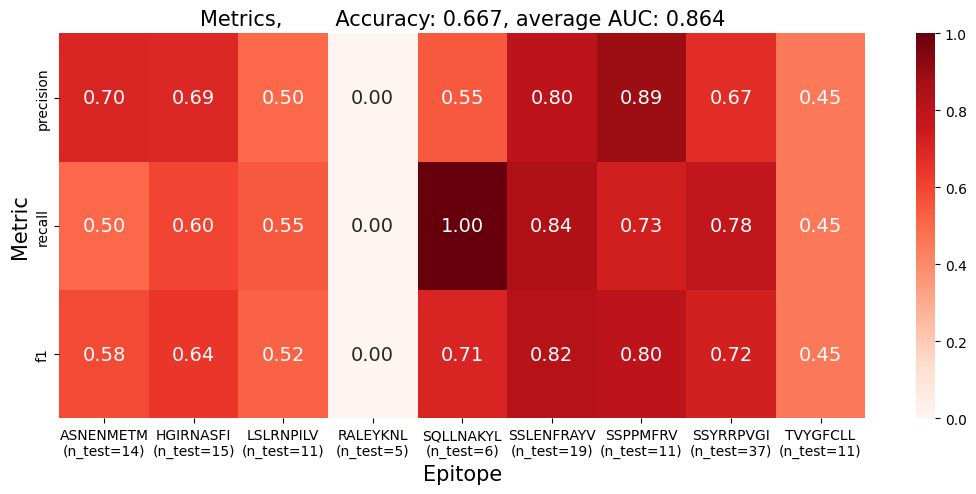

In [174]:
plt.figure(figsize=(13,5))
ax = sns.heatmap(metrics_df, annot=True, cmap='Reds', fmt='.2f', annot_kws={"size": 14}, vmin=0, vmax=1)
ax.set_ylabel('Metric', fontsize=15)
ax.set_xlabel('Epitope', fontsize=15)
ax.set_title(f"Metrics,        Accuracy: {metrics['accuracy']:.3f}, average AUC: {metrics['roc_auc']:.3f}", fontsize=15)
_ = ax.set_xticklabels([epi + f'\n(n_test={(Y_test==epi).sum()})' for epi in metrics_df.columns])

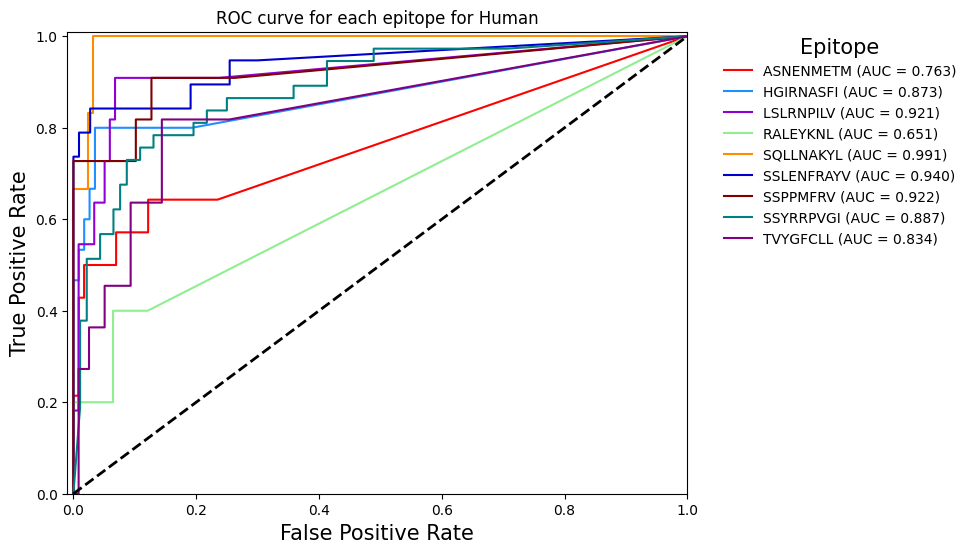

In [175]:
from tcrdist.repertoire import TCRrep
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
Y_matrix = pd.get_dummies(tcrrep_test.clone_df['epitope'])
colors = ['red', 'dodgerblue', 'darkviolet', 'lightgreen', 'darkorange', 'mediumblue', 'maroon', 'teal', 'purple', 'green', 'deepskyblue', 'yellowgreen', 'lightcoral', 'gold', ]
# Get ROC curve info for each epitope
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, ep in enumerate(model.classes_):
    fpr[ep], tpr[ep], _ = roc_curve(Y_matrix.loc[:, ep], preds_prob[:, i])
    roc_auc[ep] = auc(fpr[ep], tpr[ep])

# Plot ROC curves
fig, ax = plt.subplots(figsize=(8, 6))
for ep, color in zip(model.classes_, colors):
    ax.plot(fpr[ep], tpr[ep], color=color, lw=1.5, label=f'{ep} (AUC = {roc_auc[ep]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC curve for each epitope for Human')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False, title='Epitope')
_ = plt.setp(ax.get_legend().get_title(), fontsize=15)
plt.savefig('roc_curve_human.png')
plt.show()